É importante ressaltar que os dados do Vigitel não devem ser analisados no Excel, do pacote Office (ou programa semelhante), pois a amostra do Vigitel leva em consideração fatores de ponderação para a análise de dados.

É necessário o uso de programas como o Epi Info ou R, ou, ainda, Stata, SPSS, SAS, entre outros, que possuem módulos de análise específicos para a utilização de fatores de ponderação

Link da base: https://svs.aids.gov.br/download/Vigitel/

trabalho relacionado que usou vigitel: https://www.scielo.br/j/ress/a/6hn69ts9c5mkPjHcGBMBbGJ/?lang=pt

referências:
artigo que usa métodos de ml para prever diabetico ou não
https://www.mdpi.com/1424-8220/22/16/6155

In [ ]:
import pandas as pd 
pd.set_option('display.max_columns', 250)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from glob import glob 
import re

In [ ]:
# Machine Learning
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Para rodar necessário criar uma pasta na raiz da pasta "databetes_predictor" com o nome "data" e colocar o arquivo desejado ex: Vigitel-2019-peso-rake.xls

### Leitura de um dos dataframes referente ao ano de 2019 somente para prototipação de visualizações e entendimento dos dados

In [ ]:
# read file from google drive at folder databetes
# file_path = 'drive/My Drive/databetes/data/external/Vigitel-2021-peso-rake.xls'
# file_path = 'drive/My Drive/databetes/data/external/Vigitel-2020-peso-rake.xls'
file_path = 'drive/My Drive/databetes/data/processed/df_tratado.csv'
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df = pd.read_csv(file_path)

In [ ]:
df

,chave,replica,ano,cidade,região,sexo,idade (anos),faixa etária (anos),grau escolaridade,pressão alta,bebida alcoólica,freq alcool,exercício físico,cor,peso (kg),altura (cm),imc,classe imc,freq horta,freq refrigerante,moradores,fumante,posse plano saúde,idade início diabetes,diabetes
0,1,1,2015,Aracajú,Nordeste,masculino,59,55 a 64,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,não,branca,76.0,172.0,25.7,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,3,não,3,NaN,não
1,2,1,2015,Aracajú,Nordeste,feminino,20,18 a 24,2º grau ou colégio ou técnico ou normal ou cie...,sim,não,NaN,não,parda,84.0,162.0,32.0,obesidade classe I,5 a 6 dias por semana,1 a 2 dias por semana,7,não,3,NaN,não
2,4,1,2015,Aracajú,Nordeste,feminino,32,25 a 34,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,sim,preta,45.0,160.0,17.6,baixo peso,3 a 4 dias por semana,quase nunca,2,não,1,NaN,não
3,5,1,2015,Aracajú,Nordeste,feminino,70,65+,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,sim,parda,62.0,153.0,26.5,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,2,não,1,NaN,não
4,7,1,2015,Curitiba,Sul,feminino,84,65+,curso primário,sim,não,NaN,não,branca,51.0,140.0,26.0,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,1,não,1,84.0,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,72213241096,33,2021,São Paulo,Sudeste,feminino,72,65+,3º grau ou curso superior,não,não,NaN,não,parda,44.0,153.0,18.8,adequado ou eutrófico,quase nunca,nunca,2,não,3,NaN,não
235426,45314403046,26,2021,Belo Horizonte,Sudeste,feminino,67,65+,"pós-graduação (especialização, mestrado, douto...",sim,sim,1 a 2 dias por semana,não,parda,64.0,156.0,26.3,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,6,não,2,NaN,não
235427,26374242025,4,2021,Vitória,Sudeste,feminino,75,65+,3º grau ou curso superior,não,sim,menos de 1 dia por semana,não,parda,60.0,147.0,27.8,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,4,não,1,NaN,não
235428,22312495026,36,2021,Porto Alegre,Sul,feminino,77,65+,"pós-graduação (especialização, mestrado, douto...",sim,não,NaN,não,preta,58.0,162.0,22.1,adequado ou eutrófico,todos os dias (inclusive sábado e domingo),nunca,1,não,3,NaN,não


In [ ]:
def get_bmi_class(imc):
    if imc < 18.5:
        return 'Abaixo do peso'
    elif imc < 25:
        return 'Peso normal'
    elif imc < 30:
        return 'Sobrepeso'
    elif imc < 35:
        return 'Obesidade classe I'
    elif imc < 40:
        return 'Obesidade classe II'
    else:
        return 'Obesidade classe III'


In [ ]:
def calculate_percentage(df, col_name):
    # Group by column and calculate the percentage of each category
    col_perc = df.groupby(col_name)[col_name].count() / len(df) * 100

    # Create a new DataFrame with the percentages
    df_perc = pd.DataFrame({
        col_name: col_perc.index,
        'percentage': col_perc.values
    })

    # Map the values in the column to their respective labels
    # if col_name == 'sexo':
    #     df_perc[col_name] = df_perc[col_name].map({1: 'Man', 2: 'Female'})

    return df_perc

def dataset_percentages(df):
  """
  Receives the dataframe and returns some probabilities of desired columns
  """
  # Call the function and pass in the DataFrame and column name
  display(calculate_percentage(df, 'sexo'))

  display(calculate_percentage(df, 'faixa_etaria'))

  display(calculate_percentage(df, 'classe_imc'))

  display(calculate_percentage(df, 'cor'))

  display(calculate_percentage(df, 'pressao_alta'))

  display(calculate_percentage(df, 'bebida_alcoolica'))

  display(calculate_percentage(df, 'grau_escolaridade'))

  display(calculate_percentage(df, 'fumante'))

  display(calculate_percentage(df, 'diabetes'))


# Análise para varios anos e evolução

Definição de funções de pré processamento e plots

In [ ]:
def dataset_preprocessing(df,
                          # cols_to_keep = ['imc','hart','q42','q9_i','diab','q11','cidade','q7','fet','chave'],
                          cols_to_rename={"hart": "hipertensao", "q42": "ativo_fis","diab":"diabetes","q9_i":"peso","q11":"altura","q7":"sexo","fet":"faixa_etaria"}
                          ):
  """
  Recebe um dataframe, colunas a manter e colunas a serem renomeadas e faz o pré-processamento.
  Renomeia colunas, cria a coluna de imc e retorna o dataframe ajustado
  """
  # df= df[cols_to_keep]
  df = df.rename(columns=cols_to_rename)
  # df['imc_calc'] = df['peso'] / (df['altura'] / 100) ** 2
  # df['classe_imc'] = df['imc_calc'].apply(get_bmi_class)
  # state_abbrevs = ['SE','PA','BH','RR','MT','MS','PR','SC','CE','GO','PB','AP','AL','AM','RN','TO','RS','RO','PE','AC','RJ','BA','MA','SP','PI','ES','DF']
  diab_dict = {'sim': '1', 'não': '2'}
  df['diabetes'] = df['diabetes'].map(diab_dict)
  # use the map() method to convert state numbers to abbreviations
  # df['estado'] = df['cidade'].map(lambda x: state_abbrevs[x-1])
  # criar um dicionário que mapeia cada sigla para a região correspondente
  regioes = {'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte',
            'BA': 'Nordeste', 'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste',
            'GO': 'Centro-Oeste', 'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
            'MG': 'Sudeste', 'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul', 'PE': 'Nordeste',
            'PI': 'Nordeste', 'RJ': 'Sudeste', 'RN': 'Nordeste', 'RS': 'Sul', 'RO': 'Norte',
            'RR': 'Norte', 'SC': 'Sul', 'SP': 'Sudeste', 'SE': 'Nordeste', 'TO': 'Norte'}
  # df['regiao'] = df['estado'].map(regioes)

    # map all values greater than 5 to 5 using apply() and lambda
  df['moradores'] = df['moradores'].apply(lambda x: 6 if x > 6 else x)

  # replace values greater than 5 with "5 or more" using replace()
  df['moradores'] = df['moradores'].replace(6, '6 ou mais')
  # TODO decidir sobre os nas, tem muitos faltantes em alguns até mesmo para análise fica difícil então serão mantidos por enquanto
  # df.dropna()
  # df= df['ano'!=2022]
  return df

In [ ]:
df.columns

Index(['chave', 'replica', 'ano', 'cidade', 'região', 'sexo', 'idade (anos)',
       'faixa etária (anos)', 'grau escolaridade', 'pressão alta',
       'bebida alcoólica', 'freq alcool', 'exercício físico', 'cor',
       'peso (kg)', 'altura (cm)', 'imc', 'classe imc', 'freq horta',
       'freq refrigerante', 'moradores', 'fumante', 'posse plano saúde',
       'idade início diabetes', 'diabetes'],
      dtype='object')

In [ ]:
rename_cols_dict = {
                          'q6':'idade (anos)',
                          'classe imc': 'classe_imc',
                          # 'imc':'imc_calc',
                          'região':'regiao',
                          'q7':'sexo',
                          'civil':'estado conjugal atual',
                          'grau escolaridade':'grau_escolaridade',
                          'peso (kg)':'peso',
                          'altura (cm)':'altura',
                          #n estava em 2018# 'q15':'feijao',
                          'freq horta':'freq_horta',
                          'q25':'suco frutas',
                          'q27':'freq fruta',
                          'freq refrigerante':'freq_refrigerante',
                           #n estava em 2017# 'q30':'tipo refrigerante',
                          'bebida alcoólica':'bebida_alcoolica',
                          'freq alcool':'freq_alcool',
                          'exercício físico':'exercicio_fisico',
                          'q45':'freq exercicio',
                          'q46':'duração exercicio',
                          'q47':'trabalha',
                          'q48':'anda bastante a pé',
                          'q49':'carrega peso',
                          'q50':'trajeto a pe ou bicicleta',
                          'q51':'duração do trajeto',
                          'q52':'curso/escola',
                          'q53':'como faz trajeto curso/escola',
                          'q54':'duração trajeto curso/escola',
                          'q59a':'quantas horas assiste tv/dia',
                          # 'q60':'fumante',
                          'q61_fx':'cigarros diário (agrup. em faixas)',
                          'q61a_fx':'cigarros semanal (agrup. em faixas)',
                          # 'q62':'idade inÍcio (anos)',
                          'q64':'ex-fumante',
                          #n estava em 2018# 'r403':'aparelhos eletrônicos com nicotina',
                          'q69':'cor',
                          'q74':'estado de saúde',
                          'pressão alta':'pressao_alta',
                          'r129':'medicamento',
                          'q76':'diabetes',
                          # 'r138':'diabetes apenas na gravidez',
                          'posse plano saúde':'posse_plano_saude',
                          # 'r179':'possui celular',
                          # 'r205':'já teve depressão',
                          # 'r206':'já teve depressão',
                           'r179':'possui celular',
                          'faixa etária (anos)':'faixa_etaria',
                          'r900':'bolsa_familia',
                          'r143':'come_doce'
                               }

## Concatenando os dados de acordo com lista de anos a serem analisados

In [ ]:
years_analysis = ['2015','2016','2017','2018','2019','2020','2021']

Dessa forma, os dados são lidos de uma vez só, facilitando na hora de fazer as análises filtrando por anos. Será feita uma cópia dos dados para as análises em vários dataframes para se manter a integridade dos dados

In [ ]:
df_ = df.copy()

In [ ]:
df_

,chave,replica,ano,cidade,região,sexo,idade (anos),faixa etária (anos),grau escolaridade,pressão alta,bebida alcoólica,freq alcool,exercício físico,cor,peso (kg),altura (cm),imc,classe imc,freq horta,freq refrigerante,moradores,fumante,posse plano saúde,idade início diabetes,diabetes
0,1,1,2015,Aracajú,Nordeste,masculino,59,55 a 64,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,não,branca,76.0,172.0,25.7,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,3,não,3,NaN,não
1,2,1,2015,Aracajú,Nordeste,feminino,20,18 a 24,2º grau ou colégio ou técnico ou normal ou cie...,sim,não,NaN,não,parda,84.0,162.0,32.0,obesidade classe I,5 a 6 dias por semana,1 a 2 dias por semana,7,não,3,NaN,não
2,4,1,2015,Aracajú,Nordeste,feminino,32,25 a 34,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,sim,preta,45.0,160.0,17.6,baixo peso,3 a 4 dias por semana,quase nunca,2,não,1,NaN,não
3,5,1,2015,Aracajú,Nordeste,feminino,70,65+,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,sim,parda,62.0,153.0,26.5,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,2,não,1,NaN,não
4,7,1,2015,Curitiba,Sul,feminino,84,65+,curso primário,sim,não,NaN,não,branca,51.0,140.0,26.0,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,1,não,1,84.0,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,72213241096,33,2021,São Paulo,Sudeste,feminino,72,65+,3º grau ou curso superior,não,não,NaN,não,parda,44.0,153.0,18.8,adequado ou eutrófico,quase nunca,nunca,2,não,3,NaN,não
235426,45314403046,26,2021,Belo Horizonte,Sudeste,feminino,67,65+,"pós-graduação (especialização, mestrado, douto...",sim,sim,1 a 2 dias por semana,não,parda,64.0,156.0,26.3,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,6,não,2,NaN,não
235427,26374242025,4,2021,Vitória,Sudeste,feminino,75,65+,3º grau ou curso superior,não,sim,menos de 1 dia por semana,não,parda,60.0,147.0,27.8,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,4,não,1,NaN,não
235428,22312495026,36,2021,Porto Alegre,Sul,feminino,77,65+,"pós-graduação (especialização, mestrado, douto...",sim,não,NaN,não,preta,58.0,162.0,22.1,adequado ou eutrófico,todos os dias (inclusive sábado e domingo),nunca,1,não,3,NaN,não


Aparecem cerca de 5000 linhas de 2022, provavelmente da pesquisa de 2021, entender se dá pra usar esses dados de alguma forma

In [ ]:
df_2022 = df[df['ano']==2022]
df_2022

,chave,replica,ano,cidade,região,sexo,idade (anos),faixa etária (anos),grau escolaridade,pressão alta,bebida alcoólica,freq alcool,exercício físico,cor,peso (kg),altura (cm),imc,classe imc,freq horta,freq refrigerante,moradores,fumante,posse plano saúde,idade início diabetes,diabetes


## Análises gerais do conjunto de dados como todos os anos juntos de 2015 a 2021

,chave,replica,ano,cidade,regiao,sexo,idade (anos),faixa_etaria,grau_escolaridade,pressao_alta,bebida_alcoolica,freq_alcool,exercicio_fisico,cor,peso,altura,imc,classe_imc,freq_horta,freq_refrigerante,moradores,fumante,posse_plano_saude,idade início diabetes,diabetes
0,1,1,2015,Aracajú,Nordeste,masculino,59,55 a 64,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,não,branca,76.0,172.0,25.7,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,3,não,3,NaN,2
1,2,1,2015,Aracajú,Nordeste,feminino,20,18 a 24,2º grau ou colégio ou técnico ou normal ou cie...,sim,não,NaN,não,parda,84.0,162.0,32.0,obesidade classe I,5 a 6 dias por semana,1 a 2 dias por semana,6 ou mais,não,3,NaN,2
2,4,1,2015,Aracajú,Nordeste,feminino,32,25 a 34,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,sim,preta,45.0,160.0,17.6,baixo peso,3 a 4 dias por semana,quase nunca,2,não,1,NaN,2
3,5,1,2015,Aracajú,Nordeste,feminino,70,65+,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,sim,parda,62.0,153.0,26.5,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,2,não,1,NaN,2
4,7,1,2015,Curitiba,Sul,feminino,84,65+,curso primário,sim,não,NaN,não,branca,51.0,140.0,26.0,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,1,não,1,84.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,72213241096,33,2021,São Paulo,Sudeste,feminino,72,65+,3º grau ou curso superior,não,não,NaN,não,parda,44.0,153.0,18.8,adequado ou eutrófico,quase nunca,nunca,2,não,3,NaN,2
235426,45314403046,26,2021,Belo Horizonte,Sudeste,feminino,67,65+,"pós-graduação (especialização, mestrado, douto...",sim,sim,1 a 2 dias por semana,não,parda,64.0,156.0,26.3,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,6 ou mais,não,2,NaN,2
235427,26374242025,4,2021,Vitória,Sudeste,feminino,75,65+,3º grau ou curso superior,não,sim,menos de 1 dia por semana,não,parda,60.0,147.0,27.8,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,4,não,1,NaN,2
235428,22312495026,36,2021,Porto Alegre,Sul,feminino,77,65+,"pós-graduação (especialização, mestrado, douto...",sim,não,NaN,não,preta,58.0,162.0,22.1,adequado ou eutrófico,todos os dias (inclusive sábado e domingo),nunca,1,não,3,NaN,2


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,2.354300e+05,235430.000000,235430.000000,235430.000000,235430.000000,235430.000000,235430.000000,235430.000000,19501.000000
mean,2.710356e+10,14.516689,2017.420465,50.866466,71.178626,164.674595,26.202056,1.876367,52.550228
std,2.765805e+10,10.235338,1.741890,17.779609,13.468598,9.265477,4.235579,0.971565,12.508770
min,1.000000e+00,1.000000,2015.000000,18.000000,44.000000,140.000000,17.500000,1.000000,19.000000
25%,3.788125e+04,7.000000,2016.000000,37.000000,61.000000,158.000000,23.200000,1.000000,45.000000
50%,2.333537e+10,13.000000,2017.000000,52.000000,70.000000,165.000000,25.700000,1.000000,53.000000
75%,4.439258e+10,20.000000,2019.000000,65.000000,80.000000,170.000000,28.700000,3.000000,60.000000
max,9.951894e+10,104.000000,2021.000000,106.000000,115.000000,189.000000,41.400000,3.000000,95.000000


,sexo,percentage
0,feminino,60.866075
1,masculino,39.133925


,faixa_etaria,percentage
0,18 a 24,9.007773
1,25 a 34,12.584632
2,35 a 44,15.534129
3,45 a 54,17.776409
4,55 a 64,19.807586
5,65+,25.289470


,classe_imc,percentage
0,adequado ou eutrófico,42.347619
1,baixo peso,1.163403
2,obesidade classe I,17.818460
3,obesidade classe II,0.297328
4,sobrepeso,38.373189


,cor,percentage
0,amarela,1.414433
1,branca,47.781506
2,indígena,1.372807
3,parda,41.416982
4,preta,8.014272


,pressao_alta,percentage
0,não,67.484603
1,sim,32.515397


,bebida_alcoolica,percentage
0,não,60.755214
1,sim,39.244786


,grau_escolaridade,percentage
0,1º grau ou fundamental ou supletivo de 1º grau,12.110606
1,2º grau ou colégio ou técnico ou normal ou cie...,35.153124
2,3º grau ou curso superior,33.860596
3,admissão,0.261224
4,curso ginasial ou ginásio,2.010789
5,curso primário,6.098628
6,nunca estudou,1.189738
7,"pós-graduação (especialização, mestrado, douto...",9.315295


,fumante,percentage
0,não,92.946099
1,"sim, diariamente",5.782611
2,"sim, mas não diariamente",1.271291


,diabetes,percentage
0,1,9.768509
1,2,90.231491


,ano,diabetes,count,percentage
0,2015,1,3220,8.038144
2,2016,1,4589,10.708202
4,2017,1,3900,9.377705
6,2018,1,3781,9.143230
8,2019,1,4011,9.766015
10,2020,1,1683,10.824543
12,2021,1,1814,14.001235


<ipython-input-156-91086a65fa9c>:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=x_,y='percentage',  data=diabetes_count, legend=True,palette=palette


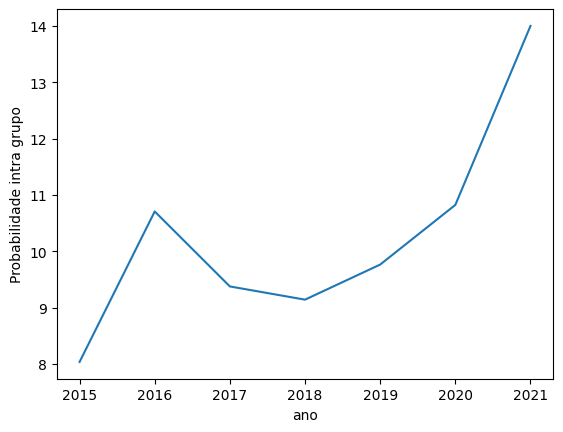

,sexo,diabetes,count,percentage
0,feminino,1,13836,9.655471
2,masculino,1,9162,9.944320


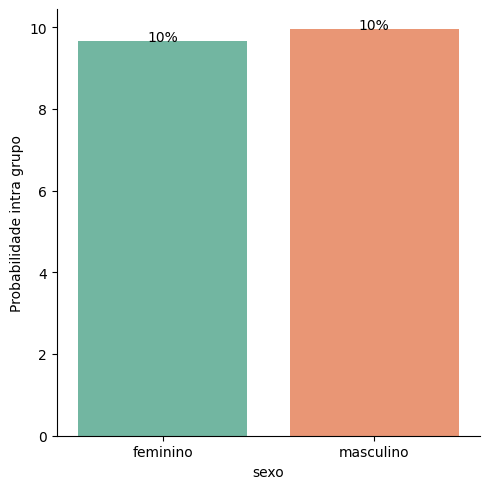

,faixa_etaria,diabetes,count,percentage
0,18 a 24,1,67,0.315933
2,25 a 34,1,333,1.123937
4,35 a 44,1,1114,3.046046
6,45 a 54,1,3044,7.273422
8,55 a 64,1,6609,14.172367
10,65+,1,11831,19.871009


<ipython-input-156-91086a65fa9c>:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=x_,y='percentage',  data=diabetes_count, legend=True,palette=palette


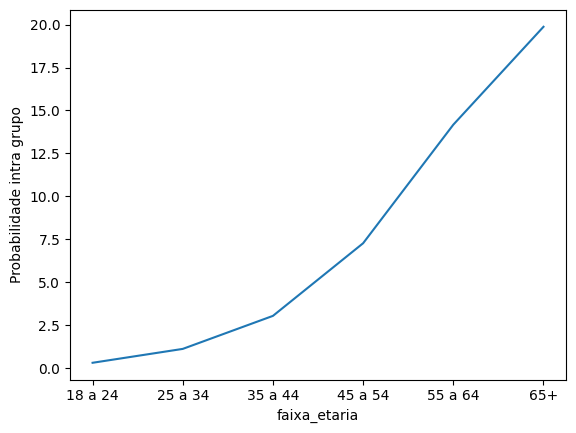

,cor,diabetes,count,percentage
0,amarela,1,362,10.870871
2,branca,1,11578,10.292287
4,indígena,1,389,12.035891
6,parda,1,8786,9.010543
8,preta,1,1883,9.979860


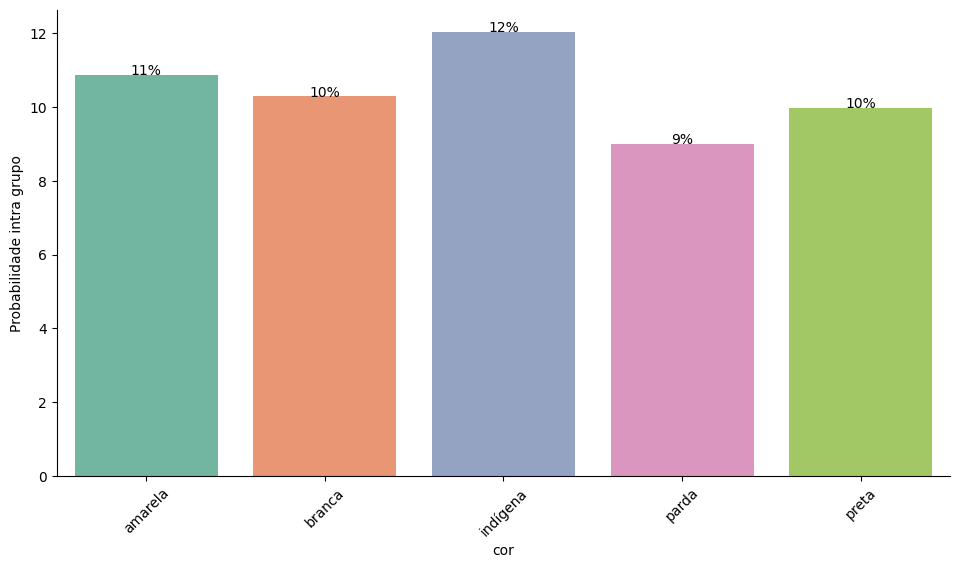

,classe_imc,diabetes,count,percentage
0,baixo peso,1,84,3.066813
1,adequado ou eutrófico,1,6152,6.170573
2,sobrepeso,1,9795,10.842133
3,obesidade classe I,1,6819,16.255066
4,obesidade classe II,1,148,21.142857


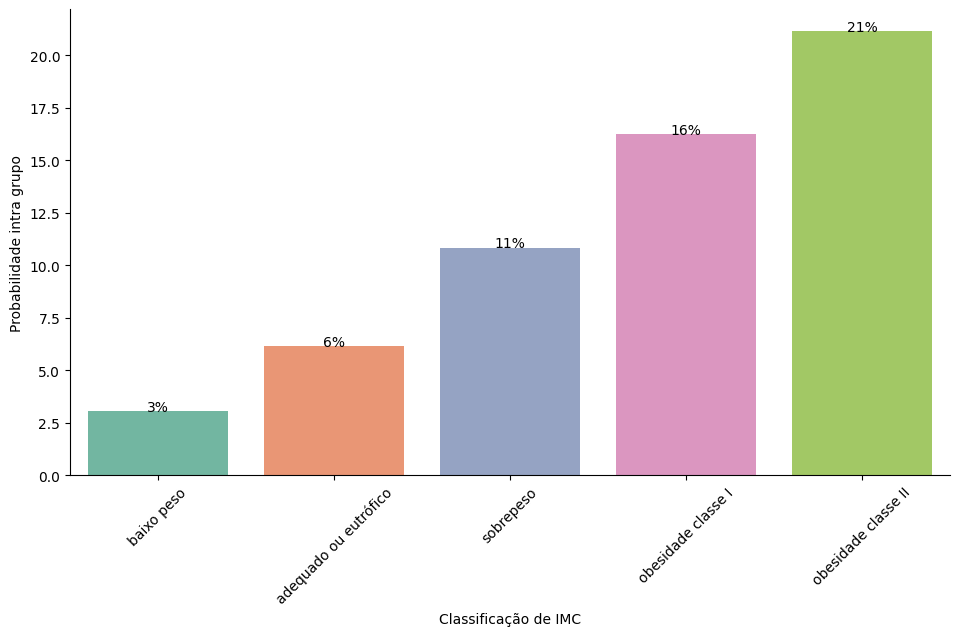

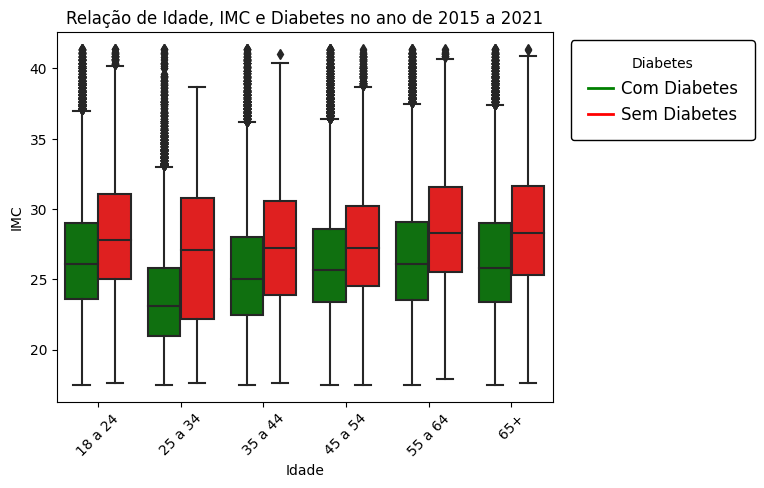

<ipython-input-156-91086a65fa9c>:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks_loc)


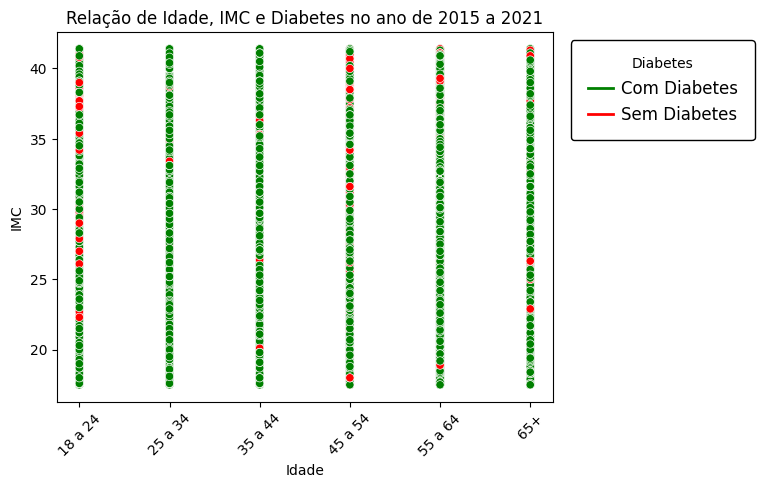

,cidade,diabetes,count,percentage
0,Aracajú,1,855,9.939549
2,Belo Horizonte,1,925,10.281205
4,Belém,1,795,8.977979
6,Boa Vista,1,542,7.358132
8,Campo Grande,1,1046,11.866137
10,Cuibá,1,901,10.148682
12,Curitiba,1,1098,11.355880
14,Distrito Federal,1,926,9.481876
16,Florianópolis,1,999,10.380299
18,Fortaleza,1,846,10.212458


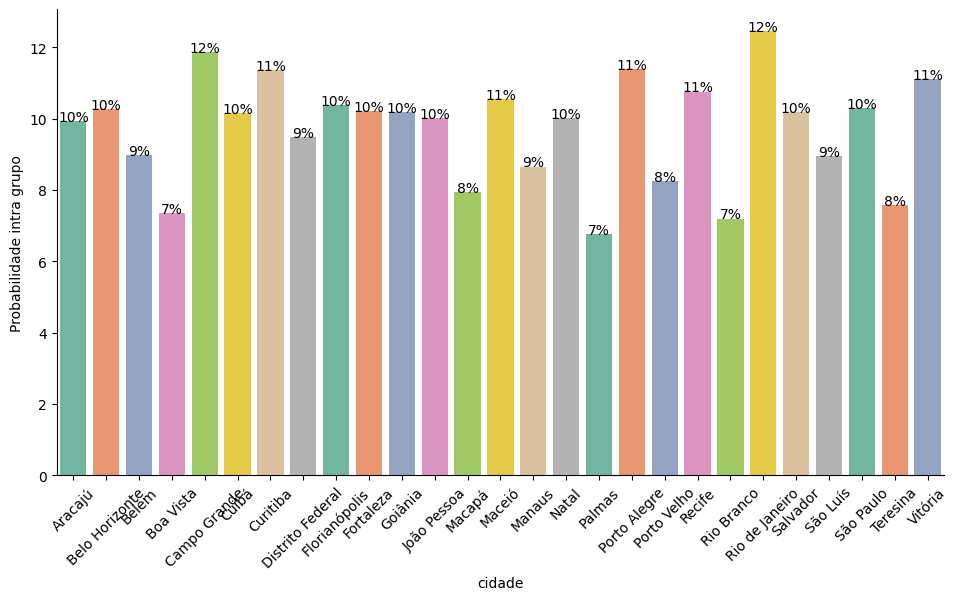

,exercicio_fisico,diabetes,count,percentage
0,não,1,11502,11.978255
2,sim,1,11496,8.246417


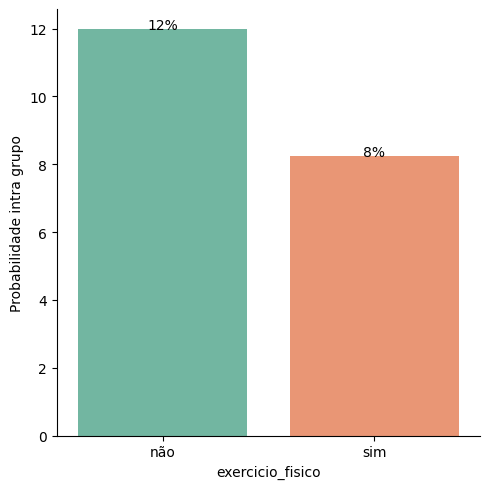

,freq_horta,diabetes,count,percentage
0,1 a 2 dias por semana,1,3485,9.796205
2,3 a 4 dias por semana,1,5945,9.860510
4,5 a 6 dias por semana,1,2999,8.082687
6,nunca,1,270,7.887818
8,quase nunca,1,601,10.153742
10,todos os dias (inclusive sábado e domingo),1,9698,10.414743


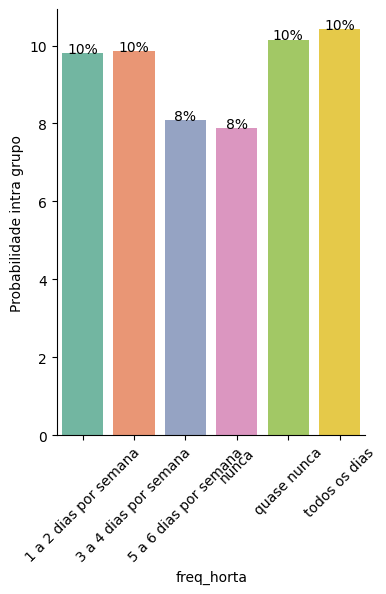

,freq_refrigerante,diabetes,count,percentage
0,nunca,1,8182,13.586171
1,quase nunca,1,6142,10.705757
2,1 a 2 dias por semana,1,5617,7.793595
3,3 a 4 dias por semana,1,1481,6.499320
4,5 a 6 dias por semana,1,496,5.454146
5,todos os dias (inclusive sábado e domingo),1,1080,7.779298


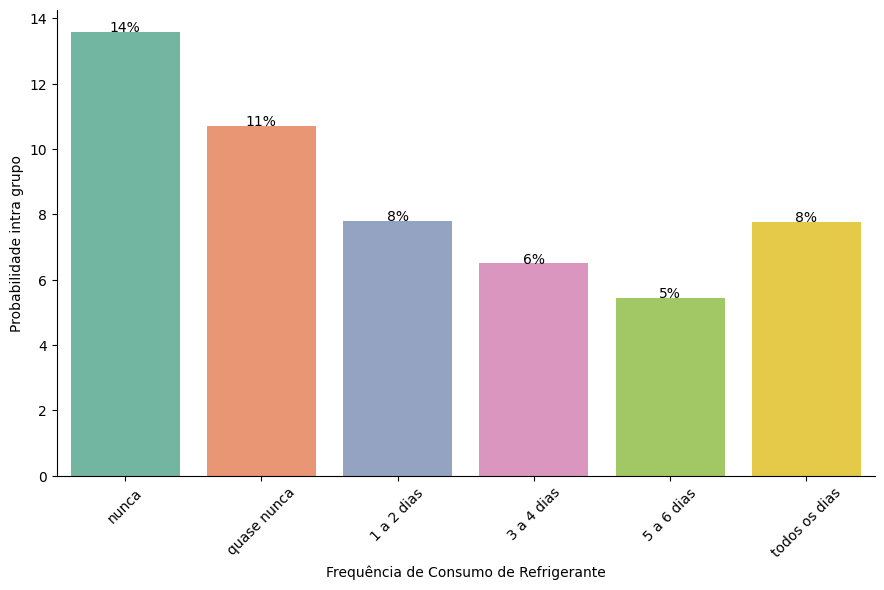

,bebida_alcoolica,diabetes,count,percentage
0,não,1,16479,11.520876
2,sim,1,6519,7.055653


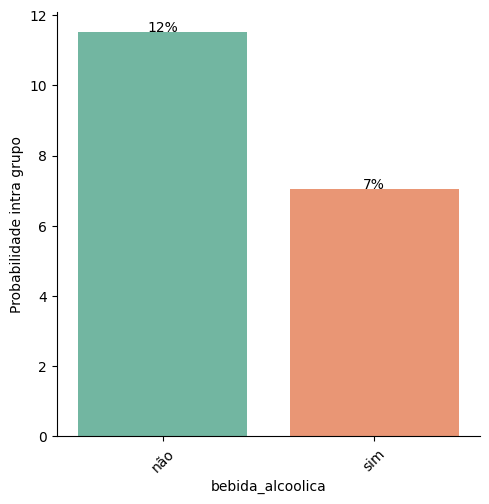

,freq_alcool,diabetes,count,percentage
0,menos de 1 dia por mês,1,1202,7.856723
1,menos de 1 dia por semana,1,1040,6.552832
2,1 a 2 dias por semana,1,3152,6.610600
3,3 a 4 dias por semana,1,618,7.055600
4,5 a 6 dias por semana,1,142,9.214796
5,todos os dias (inclusive sábado e domingo),1,365,11.255011


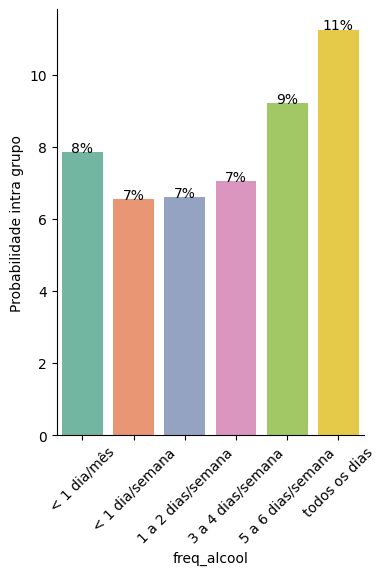

,grau_escolaridade,diabetes,count,percentage
0,nunca estudou,1,647,23.098893
1,curso primário,1,3100,21.590751
2,admissão,1,122,19.837398
3,curso ginasial ou ginásio,1,909,19.201521
4,1º grau ou fundamental ou supletivo de 1º grau,1,4178,14.653479
5,2º grau ou colégio ou técnico ou normal ou cie...,1,7303,8.824205
6,3º grau ou curso superior,1,5249,6.584460
7,"pós-graduação (especialização, mestrado, douto...",1,1490,6.794036


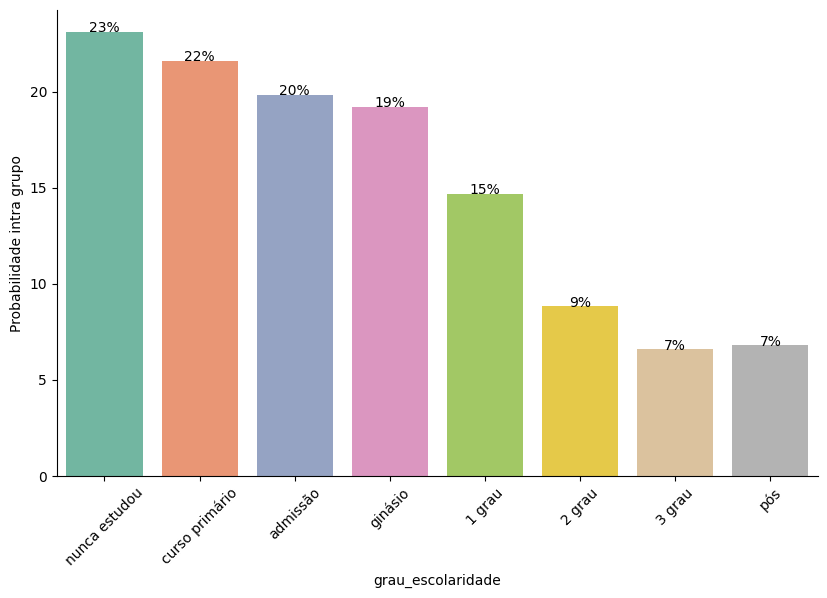

,moradores,diabetes,count,percentage
0,1,1,3663,14.370341
2,2,1,8022,13.075795
4,3,1,5172,8.735306
6,4,1,3366,6.770320
8,5,1,1645,6.789945
10,6 ou mais,1,1130,7.319601


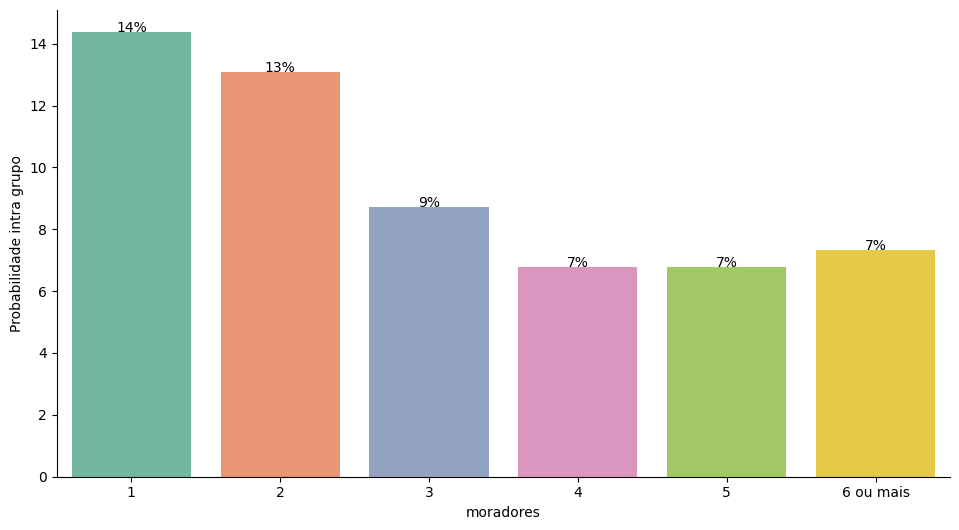

,fumante,diabetes,count,percentage
0,não,1,21560,9.852712
2,"sim, diariamente",1,1247,9.159689
4,"sim, mas não diariamente",1,191,6.381557


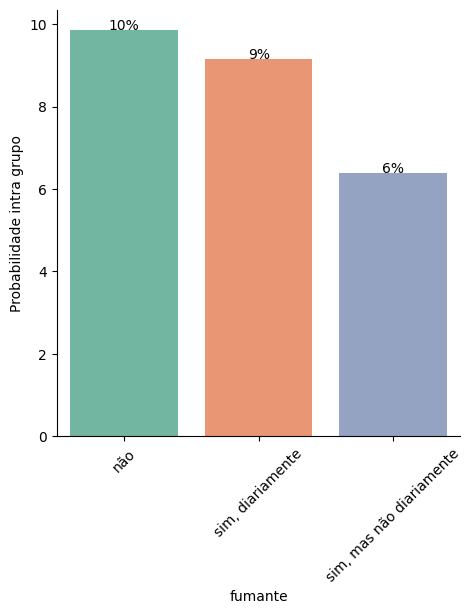

,pressao_alta,diabetes,count,percentage
0,não,1,6992,4.400833
2,sim,1,16006,20.908937


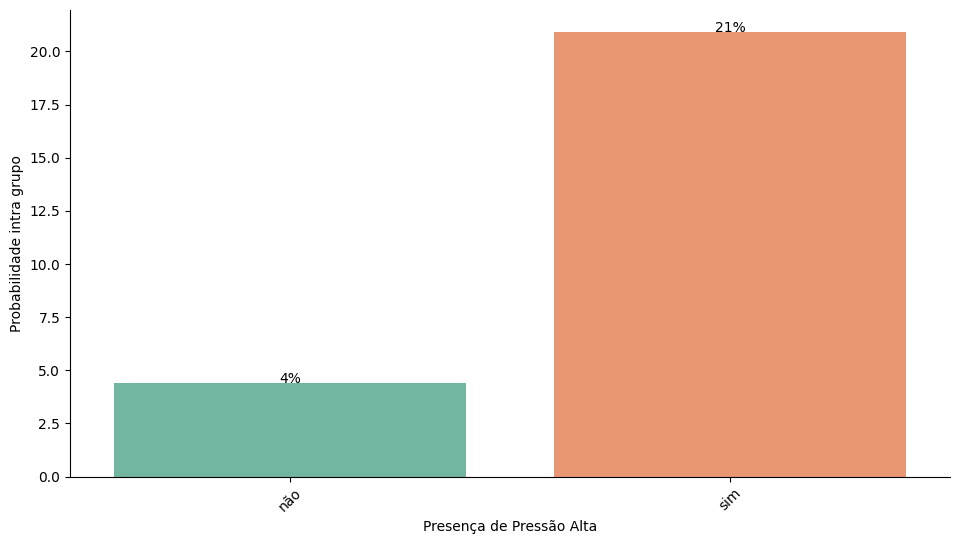

In [ ]:
def catplot_var_general(df,x_,hue_,title_,graph ='bar',height_=5,aspect_=1,x_values=None,xtick_rotation=None,display_data=True,palette=sns.color_palette("Set2"),savefig=False,path=None,sort_list=None,xlabel=None):
    """
    Faz o plot geral de uma variável categórica pelo 'hue_'. Ex: plot de sexo no x_ e hue_ diabetes irá exibir um plot relacionando os dois
    Recebe a lista de anos a serem analisados, o título, rótulos do eixo x e parâmetros opcionais de estilização
    """
    df_plot = df

    # Groupby coluna e 'diabetes' com contagem dos casos
    diabetes_count = df.groupby([x_, hue_]).size().reset_index(name='count')

    # Cálculo da porcentagem pela outra coluna
    total_per_gender = diabetes_count.groupby(x_)['count'].transform('sum')
    diabetes_count['percentage'] = diabetes_count['count'] / total_per_gender * 100
    diabetes_count = diabetes_count[diabetes_count['diabetes'].astype(int)==1]
    if sort_list != None:
      diabetes_count = diabetes_count.set_index(x_)
      diabetes_count = diabetes_count.reindex(index = sort_list)
      diabetes_count = diabetes_count.reset_index()

    if display_data == True:
      display(diabetes_count)

    if graph == 'bar':
          ax = sns.catplot(x=x_,y='percentage', kind='bar', data=diabetes_count, legend=True,height=height_,aspect=aspect_,palette=palette
                      )
    elif graph == 'line':
      ax = sns.lineplot(x=x_,y='percentage',  data=diabetes_count, legend=True,palette=palette
                    )
    
    # plt.title(f'{title_}')
    if x_values != None:
      ax.set_xticklabels(x_values)
    if xtick_rotation != None:
      plt.xticks(rotation = xtick_rotation)

    plt.ylabel('Probabilidade intra grupo')

    # Mostrar porcentagens
    total = len(df_plot)
    for p in plt.gca().patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2, height , f'{height:.0f}%', ha='center', fontsize=10)
        
    if savefig == True:
      fig1 = plt.gcf()
      fig1.savefig(path,dpi=300,bbox_inches='tight')

    if xlabel != None:
      plt.xlabel(xlabel)
    plt.show()
    plt.close()

df = df_.copy()

years_analysis = ['2015','2016','2017','2018','2019','2020','2021']

# um preprocessamento pra todos os anos
df = dataset_preprocessing(df,
                              cols_to_rename = rename_cols_dict)
display(df)

display(df.describe())

dataset_percentages(df)


catplot_var_general(df,'ano','diabetes',f'Diabetes no dataset pelos anos', 'line',height_=5.4, aspect_=9.7/5.4,savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_anos.png")

catplot_var_general(df,'sexo','diabetes',f'Diabetes por sexo nos anos de {years_analysis[0]} a {years_analysis[-1]}')

catplot_var_general(df,'faixa_etaria','diabetes',f'Diabetes por faixa etária nos anos de {years_analysis[0]} a {years_analysis[-1]}','line',savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_fet.png")

catplot_var_general(df,'cor','diabetes',f'Diabetes por cor no ano de {years_analysis[0]} a {years_analysis[-1]}',xtick_rotation=45, height_=5.4, aspect_=9.7/5.4,savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/cor.png")

catplot_var_general(df,'classe_imc','diabetes',f'Diabetes por classe_imc nos anos de {years_analysis[0]} a {years_analysis[-1]}',xtick_rotation=45, height_=5.4, aspect_=9.7/5.4,
                    savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/classeimc.png",
                    sort_list=["baixo peso","adequado ou eutrófico","sobrepeso","obesidade classe I","obesidade classe II"],
                    xlabel="Classificação de IMC")

boxplot_colors = ['green', 'red']
ax = sns.boxplot(x='faixa_etaria', y='imc', hue='diabetes', data=df,palette=boxplot_colors)# 
plt.title(f'Relação de Idade, IMC e Diabetes no ano de {years_analysis[0]} a {years_analysis[-1]}')
plt.xlabel('Idade')
plt.ylabel('IMC')
ticks_loc = ["18 a 24","25 a 34","35 a 44","45 a 54","55 a 64","65+"]
ax.set_xticklabels(ticks_loc)
plt.xticks(rotation = 45)
plt.legend(title="Diabetes", loc='upper left', facecolor='white', framealpha=1, frameon=True,
           edgecolor='black', borderpad=1, handletextpad=0.5, handlelength=1.5, bbox_to_anchor=(1.02, 1), markerscale=1, ncol=1,
           prop={'size': 12}, labels=['Com Diabetes', 'Sem Diabetes'],handles=[plt.Line2D([0], [0], color=c, lw=2) for c in boxplot_colors])
plt.show()
plt.close()


boxplot_colors = ['green', 'red']
ax = sns.scatterplot(x='faixa_etaria', y='imc', hue='diabetes', data=df,palette=boxplot_colors)
plt.title(f'Relação de Idade, IMC e Diabetes no ano de {years_analysis[0]} a {years_analysis[-1]}')
plt.xlabel('Idade')
plt.ylabel('IMC')
ticks_loc = ["18 a 24","25 a 34","35 a 44","45 a 54","55 a 64","65+"]
ax.set_xticklabels(ticks_loc)
plt.xticks(rotation = 45)
plt.legend(title="Diabetes", loc='upper left', facecolor='white', framealpha=1, frameon=True,
           edgecolor='black', borderpad=1, handletextpad=0.5, handlelength=1.5, bbox_to_anchor=(1.02, 1), markerscale=1, ncol=1,
           prop={'size': 12}, labels=['Com Diabetes', 'Sem Diabetes'],handles=[plt.Line2D([0], [0], color=c, lw=2) for c in boxplot_colors])
plt.show()
plt.close()

catplot_var_general(df,'cidade','diabetes',f'Diabetes por estado da capital no ano de {years_analysis[0]} a {years_analysis[-1]}', height_=5.4, aspect_=9.7/5.4,xtick_rotation=45
                    )

catplot_var_general(df,'exercicio_fisico','diabetes',f'Diabetes por exercicio_fisico no ano de {years_analysis[0]} a {years_analysis[-1]}',path="drive/My Drive/databetes/assets/gustavo/plots/diab_exercicio.png")

catplot_var_general(df,'freq_horta','diabetes',f'Diabetes por frequência semanal de horta no ano de {years_analysis[0]} a {years_analysis[-1]}',
                    x_values=["1 a 2 dias por semana","3 a 4 dias por semana","5 a 6 dias por semana","nunca","quase nunca","todos os dias"],xtick_rotation=45)

catplot_var_general(df,'freq_refrigerante','diabetes',f'Diabetes por frequência semanal de refrigerante no ano de {years_analysis[0]} a {years_analysis[-1]}',
                    x_values=["nunca","quase nunca","1 a 2 dias","3 a 4 dias","5 a 6 dias","todos os dias"],xtick_rotation=45, height_=5.4, aspect_=9.7/5.4,savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_freqrefri.png",
                    sort_list=["nunca","quase nunca","1 a 2 dias por semana","3 a 4 dias por semana","5 a 6 dias por semana","todos os dias (inclusive sábado e domingo)"],
                    xlabel="Frequência de Consumo de Refrigerante")

catplot_var_general(df,'bebida_alcoolica','diabetes',f'Diabetes por consumo de alcool no ano de {years_analysis[0]} a {years_analysis[-1]}',xtick_rotation=45)

catplot_var_general(df,'freq_alcool','diabetes',f'Diabetes por frequência de alcool no ano de {years_analysis[0]} a {years_analysis[-1]}',
                    x_values=["< 1 dia/mês","< 1 dia/semana","1 a 2 dias/semana","3 a 4 dias/semana","5 a 6 dias/semana","todos os dias"],xtick_rotation=45,
                     sort_list=["menos de 1 dia por mês","menos de 1 dia por semana","1 a 2 dias por semana","3 a 4 dias por semana","5 a 6 dias por semana","todos os dias (inclusive sábado e domingo)"])



catplot_var_general(df,'grau_escolaridade','diabetes',f'Diabetes por grau_escolaridade no ano de {years_analysis[0]} a {years_analysis[-1]}',
                    x_values=["nunca estudou","curso primário","admissão","ginásio","1 grau","2 grau","3 grau","pós"],xtick_rotation=45, height_=5.4, aspect_=9.7/5.4,
                    savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_grauesc.png",
                    sort_list=["nunca estudou","curso primário", "admissão", "curso ginasial ou ginásio","1º grau ou fundamental ou supletivo de 1º grau","2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau","3º grau ou curso superior",
"pós-graduação (especialização, mestrado, doutorado)"])

catplot_var_general(df,'moradores','diabetes',f'Diabetes por moradores no ano de {years_analysis[0]} a {years_analysis[-1]}', height_=5.4, aspect_=9.7/5.4)


catplot_var_general(df,'fumante','diabetes',f'Diabetes por fumante no ano de {years_analysis[0]} a {years_analysis[-1]}',xtick_rotation=45)

catplot_var_general(df,'pressao_alta','diabetes',f'Diabetes por pressão alta no ano de {years_analysis[0]} a {years_analysis[-1]}',xtick_rotation=45, height_=5.4, aspect_=9.7/5.4,
                    savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_pressaoalta.png",xlabel="Presença de Pressão Alta")




## Análises do conjunto de dados lendo ano a ano e plotando separado

Descrição geral do dataframe no ano 2015


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,40059.000000,40059.000000,40059.0,40059.000000,40059.000000,40059.000000,40059.000000,40059.000000,3220.000000
mean,26856.251928,10.925061,2015.0,48.700067,70.970717,164.897801,26.054312,1.829402,51.670807
std,15758.804310,6.272251,0.0,17.421588,13.407692,9.202502,4.207155,0.965868,12.707441
min,1.000000,1.000000,2015.0,18.000000,44.000000,140.000000,17.500000,1.000000,19.000000
25%,13128.500000,6.000000,2015.0,35.000000,60.000000,158.000000,23.000000,1.000000,44.000000
50%,26766.000000,11.000000,2015.0,49.000000,70.000000,165.000000,25.600000,1.000000,51.000000
75%,40520.500000,16.000000,2015.0,62.000000,80.000000,171.000000,28.700000,3.000000,60.000000
max,54174.000000,25.000000,2015.0,105.000000,115.000000,189.000000,41.400000,3.000000,95.000000


Descrição geral do dataframe no ano 2016


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,42855.000000,42855.000000,42855.0,42855.000000,42855.000000,42855.000000,42855.000000,42855.000000,4589.000000
mean,26387.289978,12.343484,2016.0,49.347287,71.066874,164.851173,26.102294,1.864170,52.844411
std,15314.371431,6.803014,0.0,17.586707,13.392800,9.210759,4.190679,0.967965,12.567472
min,2.000000,1.000000,2016.0,18.000000,44.000000,140.000000,17.500000,1.000000,19.000000
25%,13118.500000,7.000000,2016.0,35.000000,61.000000,158.000000,23.100000,1.000000,45.000000
50%,26248.000000,12.000000,2016.0,50.000000,70.000000,165.000000,25.600000,1.000000,53.000000
75%,39637.500000,18.000000,2016.0,63.000000,80.000000,171.000000,28.700000,3.000000,61.000000
max,53210.000000,30.000000,2016.0,105.000000,115.000000,189.000000,41.400000,3.000000,92.000000


Descrição geral do dataframe no ano 2017


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,4.158800e+04,41588.000000,41588.0,41588.000000,41588.000000,41588.000000,41588.000000,41588.000000,3900.000000
mean,4.185007e+10,11.869890,2017.0,51.030514,70.990550,164.656295,26.135421,1.867798,52.773590
std,2.339933e+10,6.812584,0.0,17.736421,13.441538,9.239069,4.211273,0.969429,12.484379
min,2.111520e+08,1.000000,2017.0,18.000000,44.000000,140.000000,17.500000,1.000000,19.000000
25%,2.433663e+10,6.000000,2017.0,37.000000,60.000000,158.000000,23.100000,1.000000,45.000000
50%,3.632776e+10,12.000000,2017.0,52.000000,70.000000,165.000000,25.700000,1.000000,53.000000
75%,5.821342e+10,18.000000,2017.0,65.000000,80.000000,170.000000,28.700000,3.000000,60.000000
max,9.951733e+10,28.000000,2017.0,101.000000,115.000000,189.000000,41.400000,3.000000,92.000000


Descrição geral do dataframe no ano 2018


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,4.135300e+04,41353.000000,41353.0,41353.000000,41353.000000,41353.000000,41353.000000,41353.000000,3781.000000
mean,4.213612e+10,15.994317,2018.0,50.826325,71.141900,164.575702,26.218702,1.882741,52.114520
std,2.424305e+10,10.314225,0.0,17.689942,13.534502,9.330805,4.251541,0.971822,12.367642
min,2.106910e+08,1.000000,2018.0,18.000000,44.000000,140.000000,17.500000,1.000000,19.000000
25%,2.339956e+10,8.000000,2018.0,37.000000,61.000000,158.000000,23.200000,1.000000,45.000000
50%,3.731160e+10,15.000000,2018.0,52.000000,70.000000,165.000000,25.700000,1.000000,52.000000
75%,5.921128e+10,23.000000,2018.0,64.000000,80.000000,171.000000,28.700000,3.000000,60.000000
max,9.951853e+10,54.000000,2018.0,106.000000,115.000000,189.000000,41.400000,3.000000,90.000000


Descrição geral do dataframe no ano 2019


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,4.107100e+04,41071.000000,41071.0,41071.000000,41071.000000,41071.000000,41071.000000,41071.000000,4011.000000
mean,4.193962e+10,17.979109,2019.0,52.724380,71.105208,164.248716,26.316415,1.902583,53.113189
std,2.363630e+10,11.294232,0.0,17.852725,13.493809,9.351011,4.284691,0.975787,12.391822
min,2.109420e+08,1.000000,2019.0,18.000000,44.000000,140.000000,17.500000,1.000000,19.000000
25%,2.432837e+10,9.000000,2019.0,39.000000,61.000000,158.000000,23.300000,1.000000,45.000000
50%,3.639914e+10,17.000000,2019.0,55.000000,70.000000,164.000000,25.800000,1.000000,54.000000
75%,5.738206e+10,26.000000,2019.0,66.000000,80.000000,170.000000,29.000000,3.000000,61.000000
max,9.951894e+10,56.000000,2019.0,106.000000,115.000000,189.000000,41.400000,3.000000,95.000000


Descrição geral do dataframe no ano 2020


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,1.554800e+04,15548.000000,15548.0,15548.000000,15548.000000,15548.000000,15548.000000,15548.000000,0.0
mean,4.112609e+10,15.598727,2020.0,51.855994,72.258104,165.091266,26.464928,1.908284,NaN
std,2.341386e+10,14.039610,0.0,17.720721,13.557861,9.225140,4.239888,0.976313,NaN
min,2.115020e+08,1.000000,2020.0,18.000000,44.000000,140.000000,17.500000,1.000000,NaN
25%,2.337453e+10,6.000000,2020.0,38.000000,62.000000,159.000000,23.500000,1.000000,NaN
50%,3.535171e+10,12.000000,2020.0,53.000000,71.000000,165.000000,26.000000,1.000000,NaN
75%,5.637249e+10,20.000000,2020.0,66.000000,80.000000,172.000000,29.000000,3.000000,NaN
max,9.951859e+10,92.000000,2020.0,102.000000,115.000000,189.000000,41.400000,3.000000,NaN


Descrição geral do dataframe no ano 2021


,chave,replica,ano,idade (anos),peso,altura,imc,posse_plano_saude,idade início diabetes
count,1.295600e+04,12956.000000,12956.0,12956.000000,12956.000000,12956.000000,12956.000000,12956.000000,0.0
mean,4.138184e+10,24.315375,2021.0,55.114233,71.849336,164.624807,26.471627,1.947669,NaN
std,2.409007e+10,16.708843,0.0,18.295374,13.517848,9.235356,4.299481,0.979785,NaN
min,2.115020e+08,1.000000,2021.0,18.000000,44.000000,140.000000,17.500000,1.000000,NaN
25%,2.337509e+10,12.000000,2021.0,41.000000,62.000000,158.000000,23.400000,1.000000,NaN
50%,3.538305e+10,22.000000,2021.0,57.000000,70.000000,165.000000,26.000000,1.000000,NaN
75%,5.735153e+10,33.000000,2021.0,69.000000,80.000000,170.000000,29.100000,3.000000,NaN
max,9.937633e+10,104.000000,2021.0,105.000000,115.000000,189.000000,41.300000,3.000000,NaN


,sexo,diabetes,count,percentage,year
0,feminino,1,1952,8.066116,2015
2,masculino,1,1268,7.995460,2015
0,feminino,1,2788,10.789891,2016
2,masculino,1,1801,10.584156,2016
0,feminino,1,2318,9.087701,2017
2,masculino,1,1582,9.837697,2017
0,feminino,1,2270,8.884888,2018
2,masculino,1,1511,9.560871,2018
0,feminino,1,2506,9.737333,2019
2,masculino,1,1505,9.814151,2019


<ipython-input-161-e8e4bc6d200f>:37: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(x="year", y="percentage", hue=x_, data=diabetes_count,palette=palette)


['feminino', 'masculino']

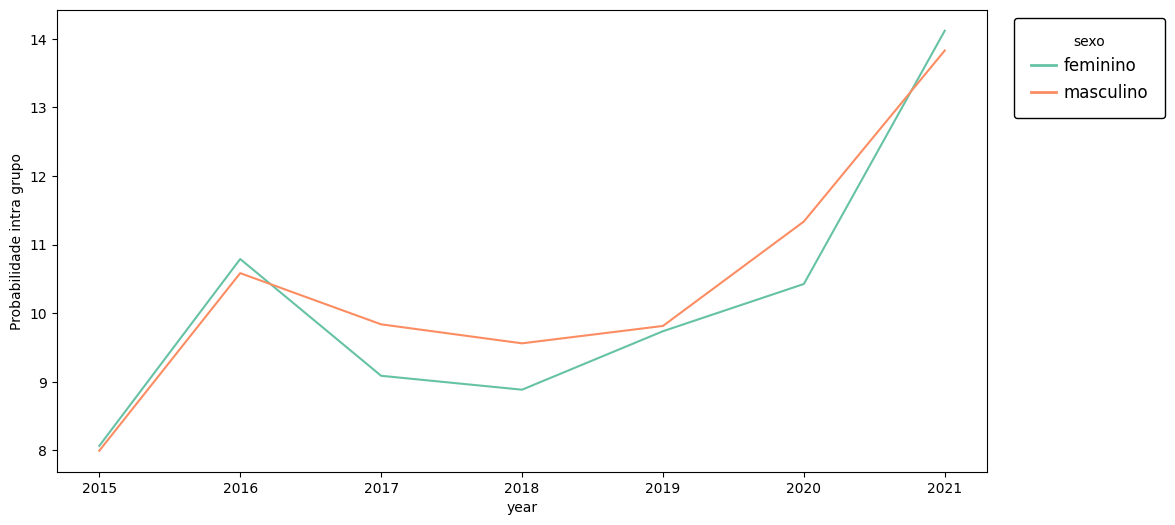

,faixa_etaria,diabetes,count,percentage,year
0,18 a 24,1,13,0.324919,2015
2,25 a 34,1,53,0.899220,2015
4,35 a 44,1,195,2.882910,2015
6,45 a 54,1,480,6.328279,2015
8,55 a 64,1,988,13.013699,2015
10,65+,1,1491,18.132069,2015
0,18 a 24,1,13,0.304664,2016
2,25 a 34,1,84,1.376598,2016
4,35 a 44,1,264,3.847275,2016
6,45 a 54,1,705,8.906013,2016


<ipython-input-161-e8e4bc6d200f>:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  ax = sns.lineplot(x="year", y="percentage", hue=x_, data=diabetes_count,palette=palette)


['18 a 24', '25 a 34', '35 a 44', '45 a 54', '55 a 64', '65+']

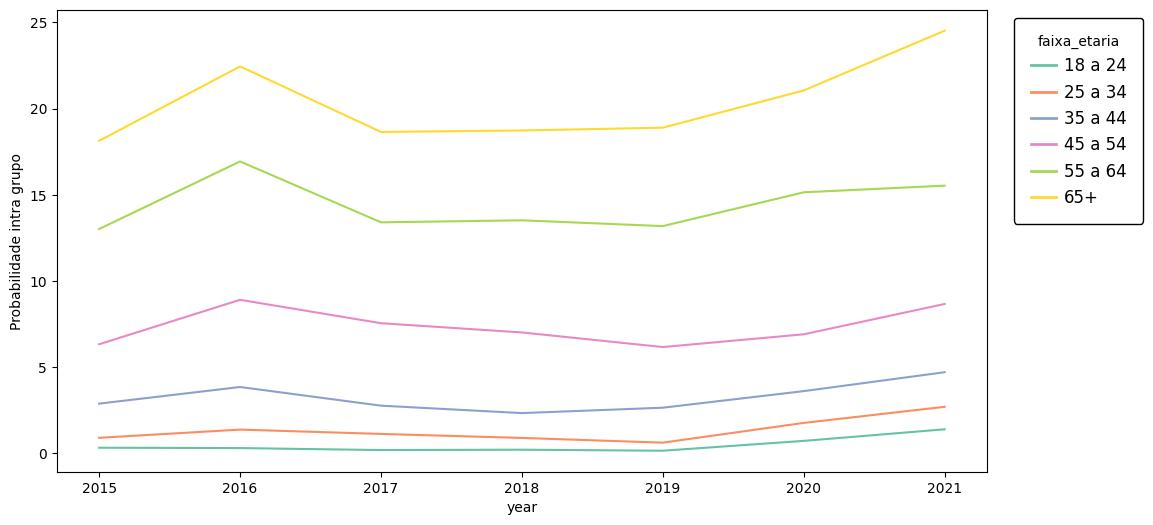

,classe_imc,diabetes,count,percentage,year
0,adequado ou eutrófico,1,863,4.920463,2015
2,baixo peso,1,11,2.291667,2015
4,obesidade classe I,1,972,14.351100,2015
6,obesidade classe II,1,24,20.338983,2015
8,sobrepeso,1,1350,8.911479,2015
0,adequado ou eutrófico,1,1202,6.526224,2016
2,baixo peso,1,19,3.564728,2016
4,obesidade classe I,1,1387,18.827202,2016
6,obesidade classe II,1,23,20.909091,2016
8,sobrepeso,1,1958,11.919401,2016


<ipython-input-161-e8e4bc6d200f>:37: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  ax = sns.lineplot(x="year", y="percentage", hue=x_, data=diabetes_count,palette=palette)


['adequado ou eutrófico',
 'baixo peso',
 'obesidade classe I',
 'obesidade classe II',
 'sobrepeso']

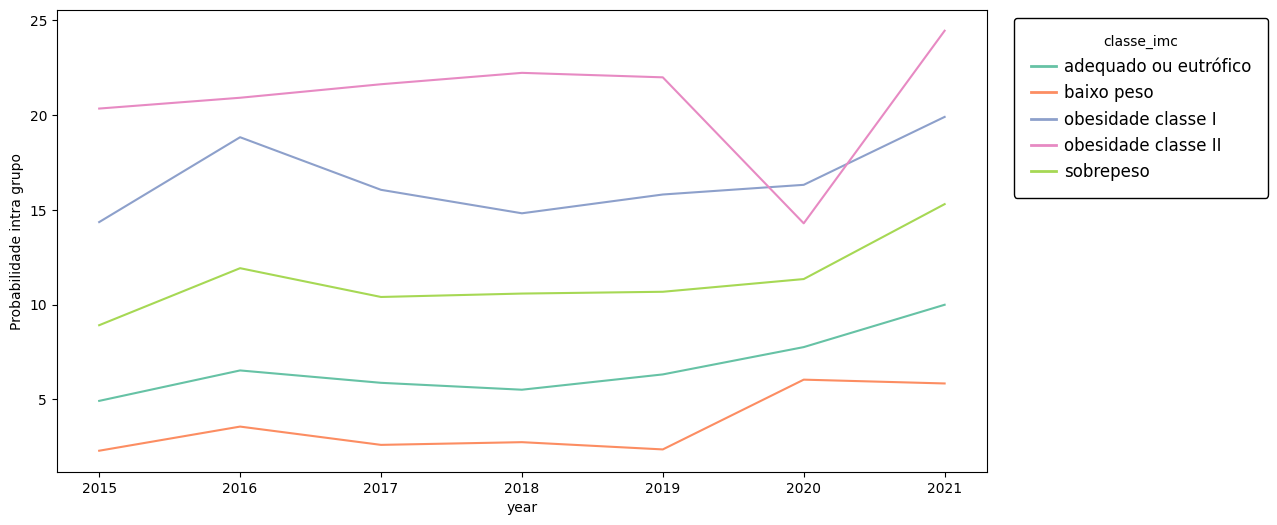

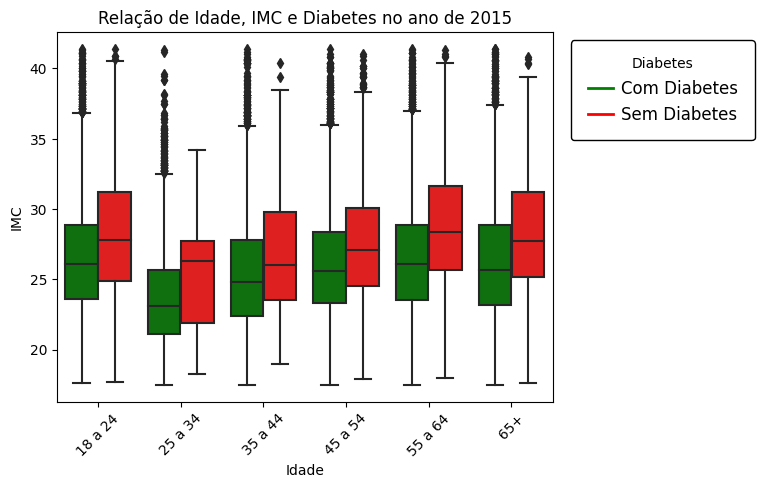

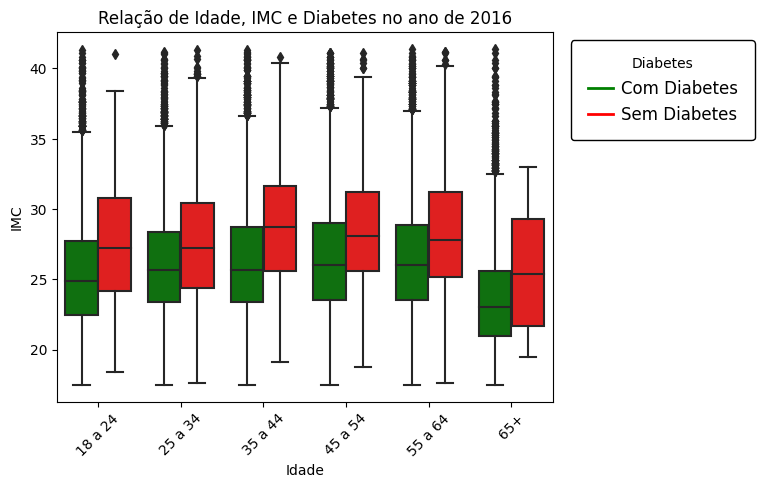

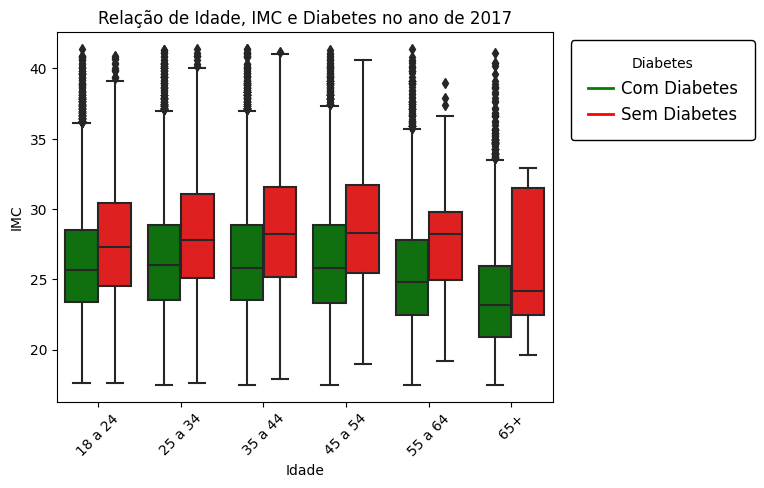

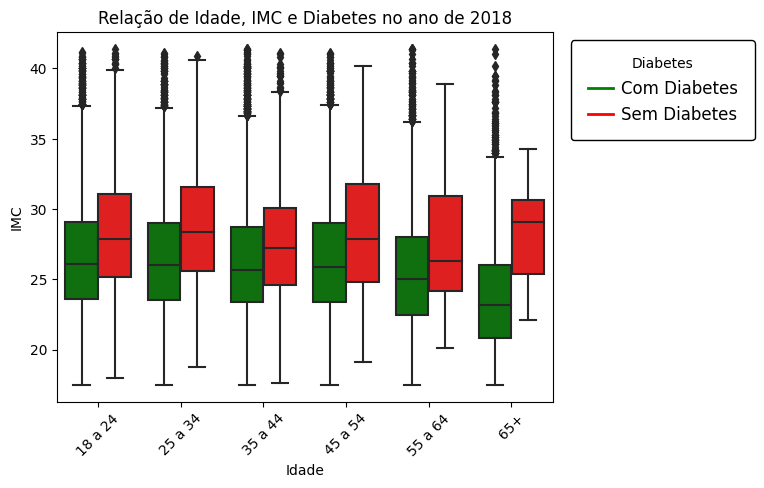

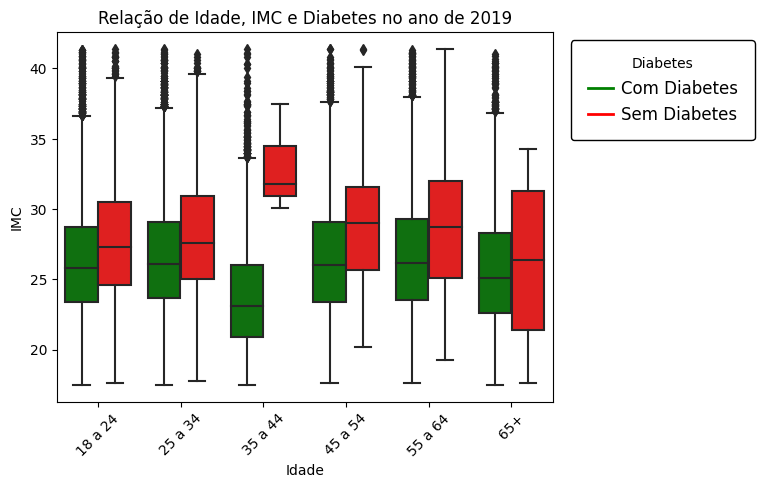

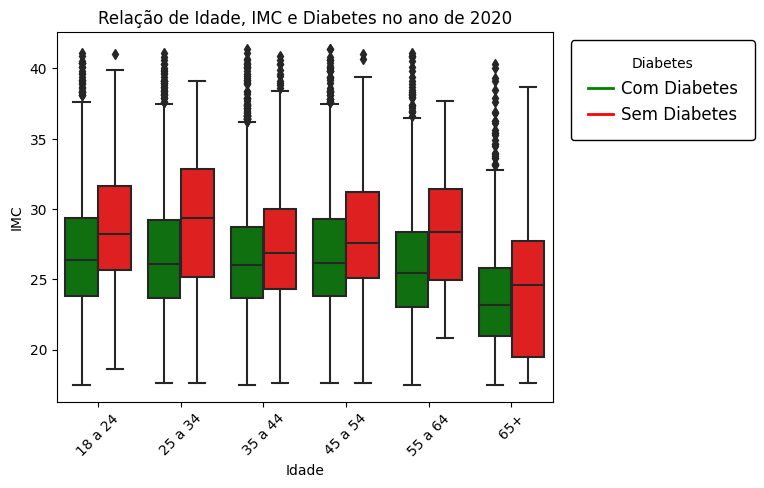

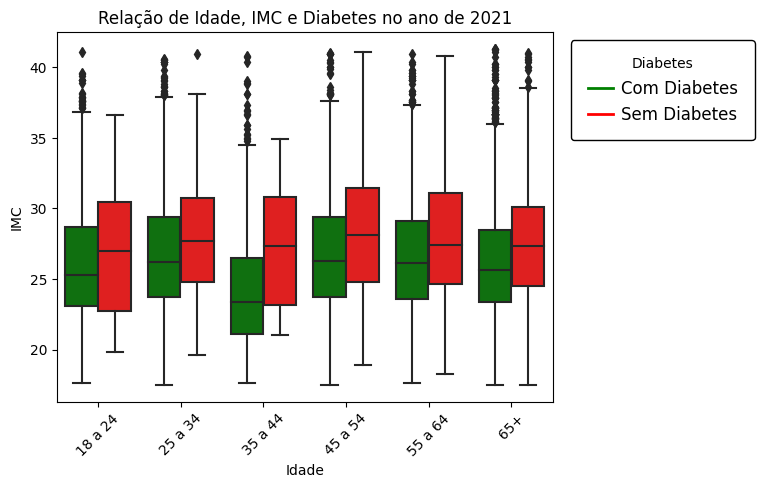

,regiao,diabetes,count,percentage,year
0,Centro-Oeste,1,548,8.897548,2015
2,Nordeste,1,1004,8.152659,2015
4,Norte,1,742,6.961907,2015
6,Sudeste,1,501,8.261873,2015
8,Sul,1,425,8.739461,2015
0,Centro-Oeste,1,756,11.564938,2016
2,Nordeste,1,1471,10.767879,2016
4,Norte,1,932,8.414590,2016
6,Sudeste,1,793,12.179389,2016
8,Sul,1,637,12.564103,2016


['Centro-Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul']

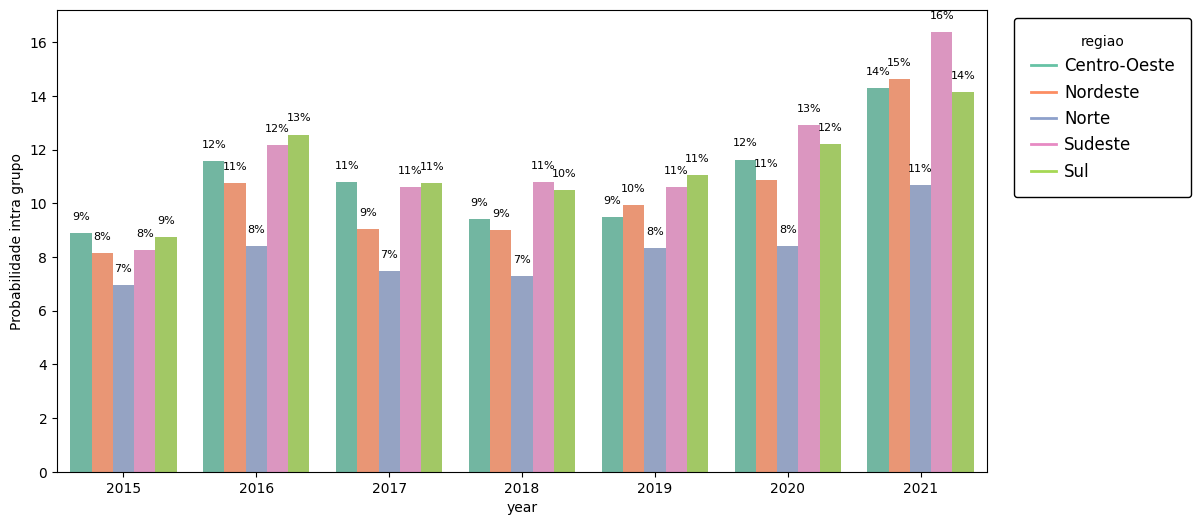

,exercicio_fisico,diabetes,count,percentage,year
0,não,1,1646,9.685771,2015
2,sim,1,1574,6.824192,2015
0,não,1,2346,12.967057,2016
2,sim,1,2243,9.057869,2016
0,não,1,2006,11.706349,2017
2,sim,1,1894,7.745788,2017
0,não,1,1817,11.316642,2018
2,sim,1,1964,7.763766,2018
0,não,1,1950,11.952191,2019
2,sim,1,2061,8.325254,2019


<ipython-input-161-e8e4bc6d200f>:37: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(x="year", y="percentage", hue=x_, data=diabetes_count,palette=palette)


['não', 'sim']

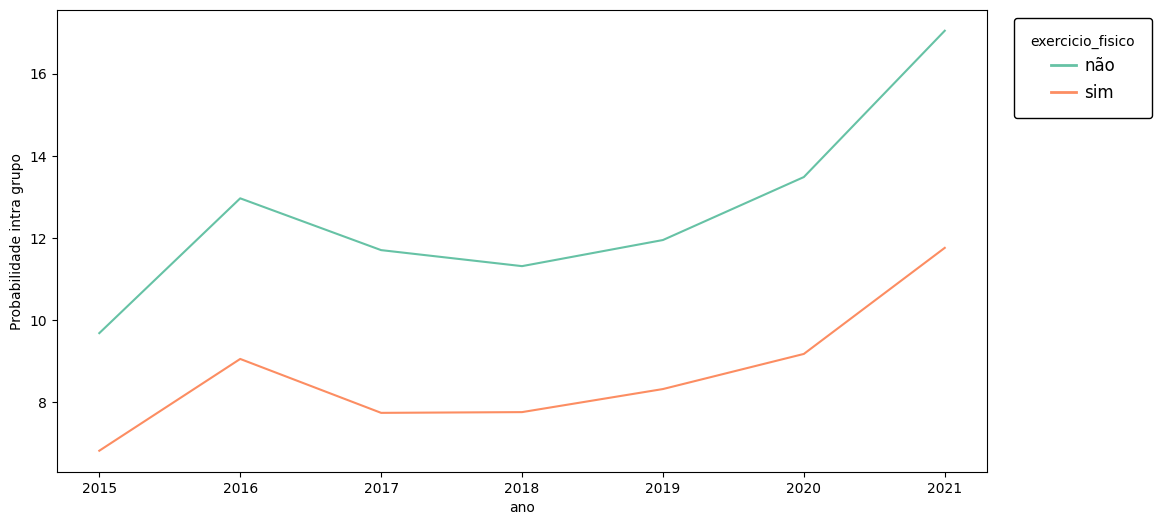

,freq_horta,diabetes,count,percentage,year
0,1 a 2 dias por semana,1,431,7.885108,2015
2,3 a 4 dias por semana,1,679,7.322334,2015
4,5 a 6 dias por semana,1,419,6.288459,2015
6,nunca,1,64,7.582938,2015
8,quase nunca,1,109,10.234742,2015
10,todos os dias (inclusive sábado e domingo),1,1518,9.063769,2015
0,1 a 2 dias por semana,1,700,10.976948,2016
2,3 a 4 dias por semana,1,1177,10.756717,2016
4,5 a 6 dias por semana,1,603,8.883324,2016
6,nunca,1,50,8.771930,2016


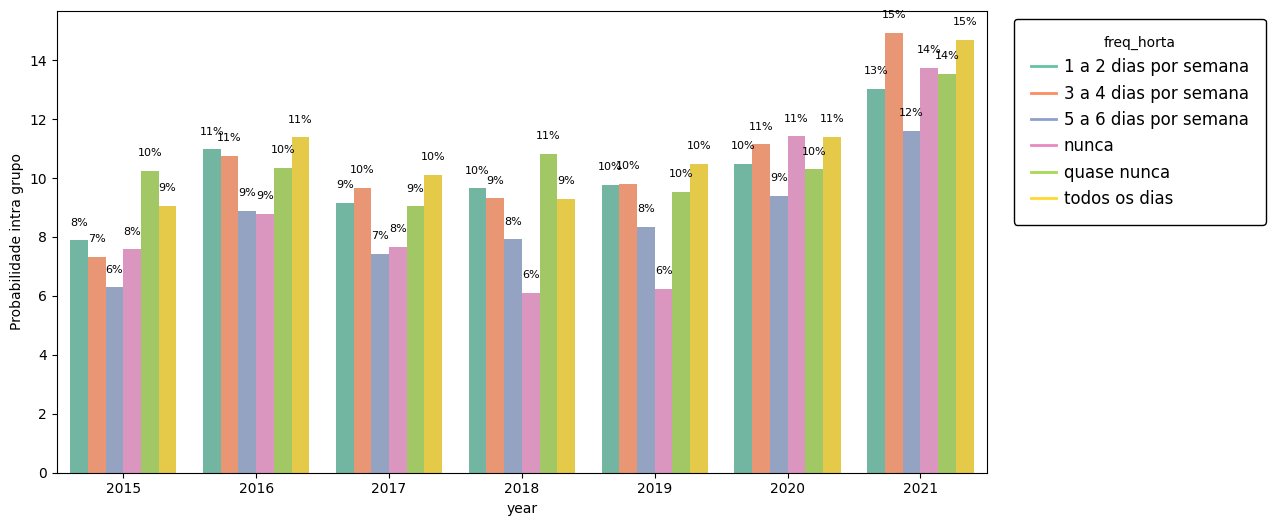

,freq_refrigerante,diabetes,count,percentage,year
0,1 a 2 dias por semana,1,726,6.029400,2015
2,3 a 4 dias por semana,1,202,4.799240,2015
4,5 a 6 dias por semana,1,82,4.198669,2015
6,nunca,1,1246,11.592854,2015
8,quase nunca,1,789,9.820762,2015
10,todos os dias (inclusive sábado e domingo),1,175,5.692908,2015
0,1 a 2 dias por semana,1,1293,8.805503,2016
2,3 a 4 dias por semana,1,342,6.983868,2016
4,5 a 6 dias por semana,1,107,5.652404,2016
6,nunca,1,1447,15.148660,2016


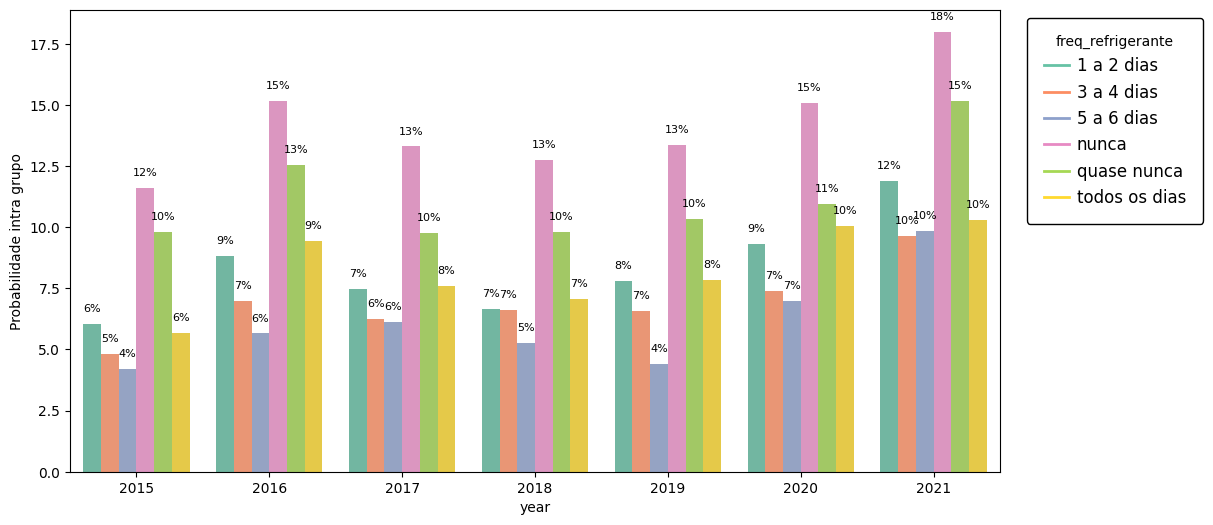

,bebida_alcoolica,diabetes,count,percentage,year
0,não,1,2426,9.326106,2015
2,sim,1,794,5.652855,2015
0,não,1,3323,12.536311,2016
2,sim,1,1266,7.744067,2016
0,não,1,2792,10.837247,2017
2,sim,1,1108,7.001580,2017
0,não,1,2795,10.883109,2018
2,sim,1,986,6.291877,2018
0,não,1,3063,11.832651,2019
2,sim,1,948,6.243003,2019


['não', 'sim']

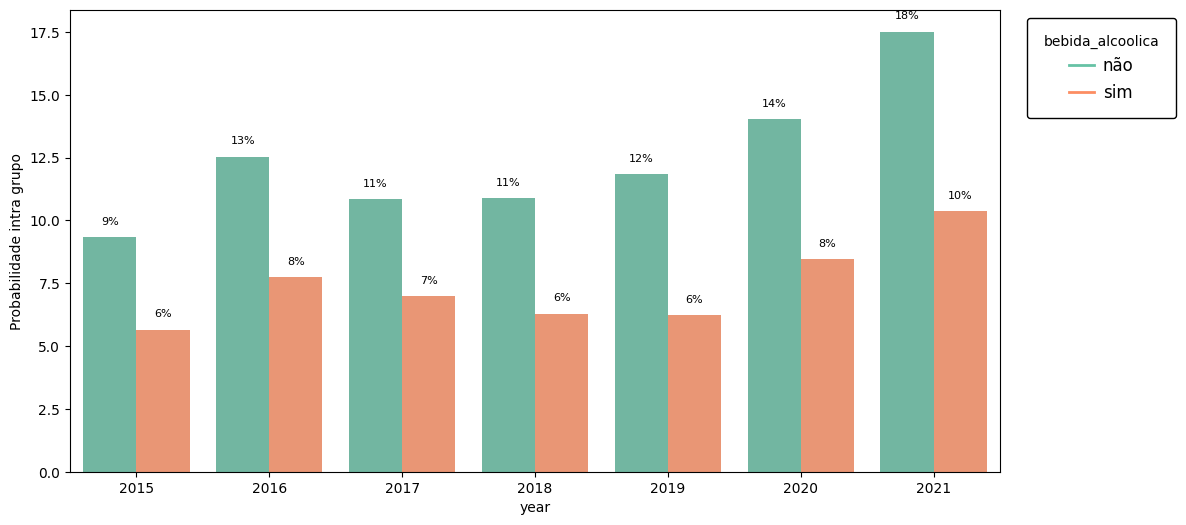

,freq_alcool,diabetes,count,percentage,year
0,menos de 1 dia por mês,1,150,6.493506,2015
1,menos de 1 dia por semana,1,94,5.414747,2015
2,1 a 2 dias por semana,1,396,5.003159,2015
3,3 a 4 dias por semana,1,77,5.833333,2015
4,5 a 6 dias por semana,1,20,8.474576,2015
5,todos os dias (inclusive sábado e domingo),1,57,10.775047,2015
0,menos de 1 dia por mês,1,234,9.083851,2016
1,menos de 1 dia por semana,1,164,6.302844,2016
2,1 a 2 dias por semana,1,624,7.155963,2016
3,3 a 4 dias por semana,1,140,8.631319,2016


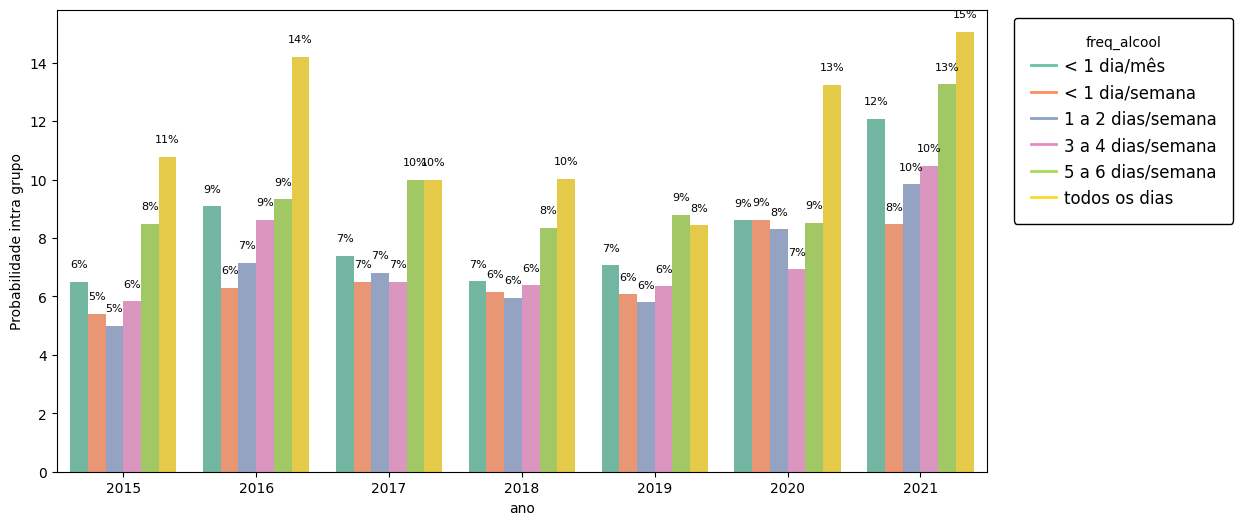

,grau_escolaridade,diabetes,count,percentage,year
0,1º grau ou fundamental ou supletivo de 1º grau,1,681,12.576177,2015
2,2º grau ou colégio ou técnico ou normal ou cie...,1,1061,7.160694,2015
4,3º grau ou curso superior,1,711,5.344257,2015
6,admissão,1,9,16.071429,2015
8,curso ginasial ou ginásio,1,113,17.711599,2015
10,curso primário,1,362,19.770617,2015
12,nunca estudou,1,76,20.320856,2015
14,"pós-graduação (especialização, mestrado, douto...",1,207,5.711921,2015
0,1º grau ou fundamental ou supletivo de 1º grau,1,838,16.013759,2016
2,2º grau ou colégio ou técnico ou normal ou cie...,1,1428,9.525080,2016


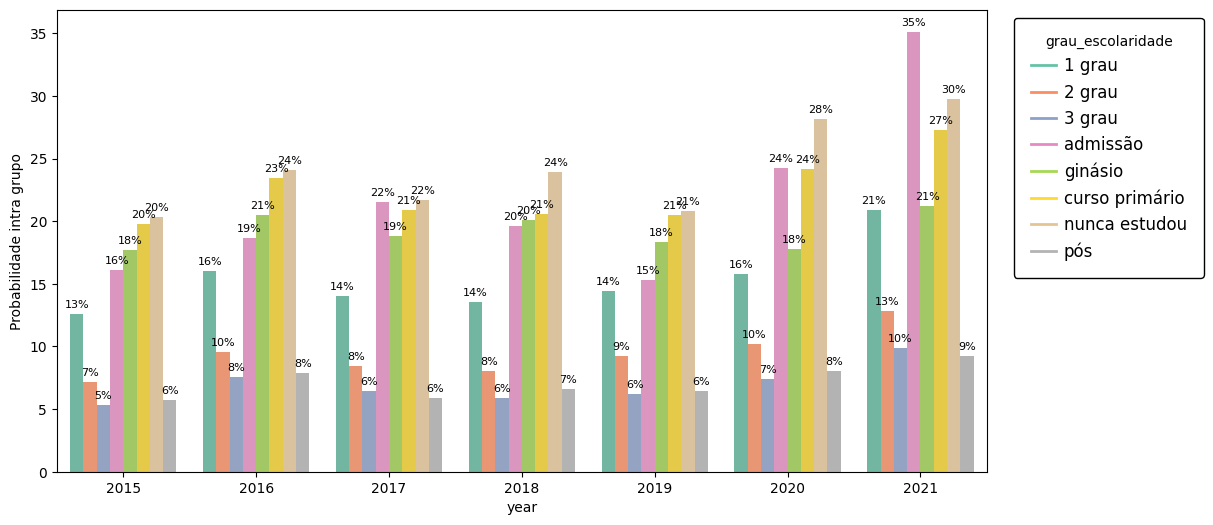

,moradores,diabetes,count,percentage,year
0,1,1,502,11.756440,2015
2,2,1,1040,10.816433,2015
4,3,1,770,7.704623,2015
6,4,1,475,5.353319,2015
8,5,1,250,5.699954,2015
10,6 ou mais,1,183,6.264978,2015
0,1,1,701,16.111239,2016
2,2,1,1539,14.658539,2016
4,3,1,1006,9.323448,2016
6,4,1,704,7.494145,2016


[1, 2, 3, 4, 5, '6 ou mais']

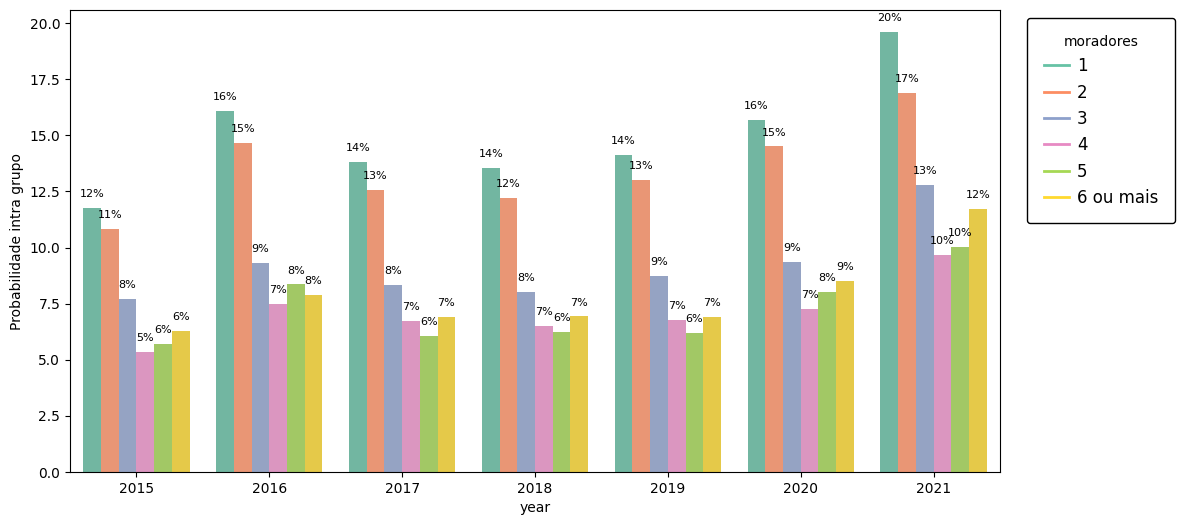

,fumante,diabetes,count,percentage,year
0,não,1,3023,8.138377,2015
2,"sim, diariamente",1,174,7.160494,2015
4,"sim, mas não diariamente",1,23,4.752066,2015
0,não,1,4292,10.799386,2016
2,"sim, diariamente",1,263,10.269426,2016
4,"sim, mas não diariamente",1,34,6.170599,2016
0,não,1,3643,9.405174,2017
2,"sim, diariamente",1,219,9.423408,2017
4,"sim, mas não diariamente",1,38,7.169811,2017
0,não,1,3565,9.216173,2018


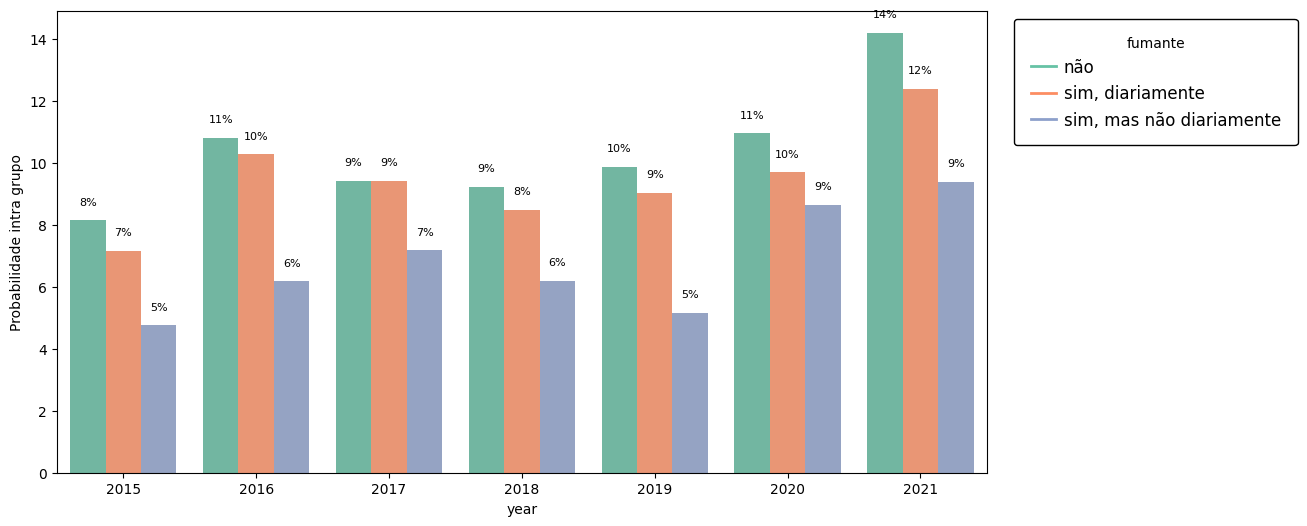

,pressao_alta,diabetes,count,percentage,year
0,não,1,1011,3.603764,2015
2,sim,1,2209,18.400666,2015
0,não,1,1444,4.949104,2016
2,sim,1,3145,22.993128,2016
0,não,1,1200,4.280975,2017
2,sim,1,2700,19.915911,2017
0,não,1,1160,4.125911,2018
2,sim,1,2621,19.799063,2018
0,não,1,1135,4.198727,2019
2,sim,1,2876,20.485790,2019


['não', 'sim']

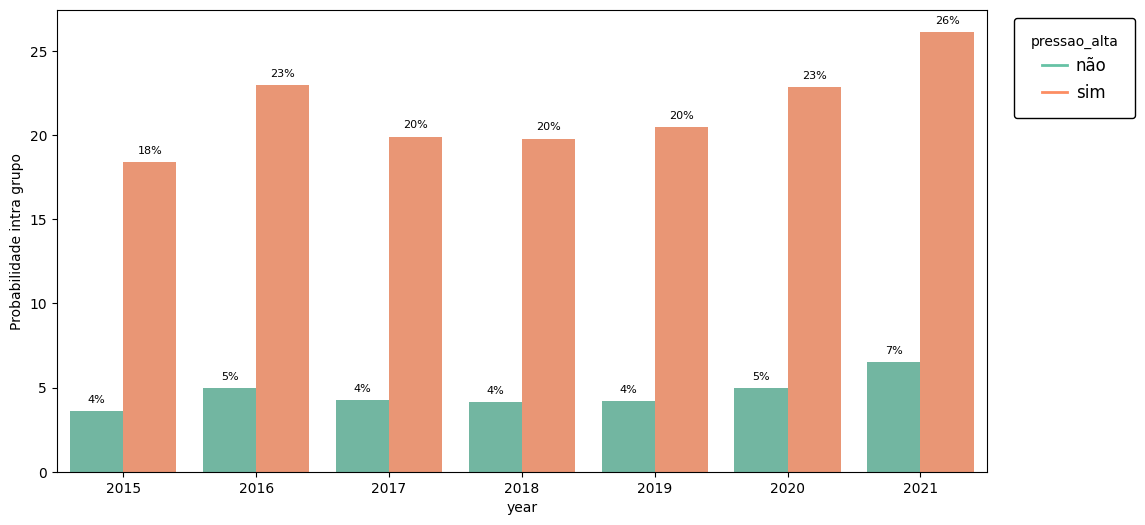

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [161]:
def catplot_var(df,years_list,x_,hue_,title_,graph='bar',height_=5,aspect_=1,x_values=None,xtick_rotation=None,display_data=True,show_perc=True,figsize_=(12, 6),palette=sns.color_palette("Set2"),savefig=False,path=None,sort_list=None,xlabel=None):
    """
    Faz o plot por anos de uma variável categórica pelo 'hue_'. Ex: plot de sexo no x_ e hue_ diabetes irá exibir um plot relacionando os dois
    Recebe a lista de anos a serem analisados, o título, rótulos do eixo x e parâmetros opcionais de estilização
    """
    appended_data = []
    for year in years_list:
      # try:
      df_plot = df[df['ano']==int(year)]

      # Group the data by 'sexo' and 'diabetes', and count the number of cases
      diabetes_count = df_plot.groupby([x_, hue_]).size().reset_index(name='count')

      # Calculate the percentage of diabetes cases per gender
      total_per_gender = diabetes_count.groupby(x_)['count'].transform('sum')
      diabetes_count['percentage'] = diabetes_count['count'] / total_per_gender * 100
      diabetes_count = diabetes_count[diabetes_count['diabetes'].astype(int)==1]
      diabetes_count['year'] = year
      if sort_list != None:
        diabetes_count = diabetes_count.set_index(x_)
        diabetes_count = diabetes_count.reindex(index = sort_list)
        diabetes_count = diabetes_count.reset_index()

      appended_data.append(diabetes_count)

    appended_data = pd.concat(appended_data)

    diabetes_count = appended_data

    if display_data == True:
      display(diabetes_count)
    if graph == 'bar':
      # ax = sns.catplot(x=x_,y='percentage', hue=hue_, kind='bar', data=diabetes_count, legend=True,height=height_,aspect=aspect_,
      #             )
      ax = sns.barplot(x="year", y="percentage", hue=x_, data=diabetes_count,palette=palette)
    elif graph == 'line':
      ax = sns.lineplot(x="year", y="percentage", hue=x_, data=diabetes_count,palette=palette)
    elif graph == 'point':
      ax = sns.violinplot(x="year", y="percentage",hue=x_, data=diabetes_count,palette=palette,
             split=True, inner="stick")

    fig = plt.gcf()
    fig.set_size_inches(figsize_)
    # ax.set_aspect(aspect_)
    # plt.title(f'{title_}')
    # if x_values != None:
    #   ax.set_xticklabels(x_values)
    # if xtick_rotation != None:
    #   plt.xticks(rotation = xtick_rotation)

    # plt.legend(['Com diabetes','Sem diabetes'])
    if x_values != None:
      legend_colors = palette
      plt.legend(title=x_, labels=x_values, loc="upper left", facecolor="white",
                framealpha=1, frameon=True, edgecolor="black", borderpad=1, 
                handletextpad=0.5, handlelength=1.5, bbox_to_anchor=(1.02, 1),
                markerscale=1, ncol=1, prop={"size":12}, 
                handles=[plt.Line2D([0], [0], color=c, lw=2) for c in legend_colors])
    else:
      legend_labels = diabetes_count[x_].unique().tolist()
      display(legend_labels)
      legend_colors = palette
      plt.legend(title=x_, labels=legend_labels, loc="upper left", facecolor="white",
                framealpha=1, frameon=True, edgecolor="black", borderpad=1, 
                handletextpad=0.5, handlelength=1.5, bbox_to_anchor=(1.02, 1),
                markerscale=1, ncol=1, prop={"size":12}, 
                handles=[plt.Line2D([0], [0], color=c, lw=2) for c in legend_colors])
    plt.ylabel('Probabilidade intra grupo')
    # Mostrar porcentagens
    if show_perc == True:
      total = len(df_plot)
      for p in plt.gca().patches:
          height = p.get_height()
          plt.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{height:.0f}%', ha='center', fontsize=8)
    if xlabel != None:
      plt.xlabel(xlabel)
    if savefig == True:
      fig1 = plt.gcf()
      fig1.savefig(path,dpi=100,bbox_inches='tight')
    
    plt.show()
    plt.close()
    return plt

      # except:
      #   print(f"problema com plot de {title_} no ano {year}")

df = df_.copy()
# years_analysis = ['2017','2018','2019','2020','2021','2022']
years_analysis = ['2015','2016','2017','2018','2019','2020','2021']
# display(df)
# um preprocessamento pra todos os anos
df = dataset_preprocessing(df,
                              cols_to_rename = rename_cols_dict)

# descritivas por ano
for year in years_analysis:
  df_plot = df[df['ano']==int(year)]
  print(f"Descrição geral do dataframe no ano {year}")
  display(df_plot.describe())



catplot_var(df,years_analysis,'sexo','diabetes',f'Diabetes por sexo ao longo dos anos ',graph='line')

# x = catplot_var(df,years_analysis,'cor','diabetes',f'Diabetes por cor ao longo dos anos',xtick_rotation=45,savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_cor.png")

catplot_var(df,years_analysis,'faixa_etaria','diabetes',f'Diabetes por faixa etária ao longo dos anos',graph='line')

catplot_var(df,years_analysis,'classe_imc','diabetes',f'Diabetes por classe_imc ao longo dos anos',graph='line',xtick_rotation=45)


for year in years_analysis:
  # try:
  df_plot = df[df['ano']==int(year)]
  boxplot_colors = ['green', 'red']
  ax = sns.boxplot(x='faixa_etaria', y='imc', hue='diabetes', data=df_plot,palette=boxplot_colors)# 
  plt.title(f'Relação de Idade, IMC e Diabetes no ano de {year}')
  plt.xlabel('Idade')
  plt.ylabel('IMC')
  ticks_loc = ["18 a 24","25 a 34","35 a 44","45 a 54","55 a 64","65+"]
  ax.set_xticklabels(ticks_loc)
  plt.xticks(rotation = 45)
  plt.legend(title="Diabetes", loc='upper left', facecolor='white', framealpha=1, frameon=True,
            edgecolor='black', borderpad=1, handletextpad=0.5, handlelength=1.5, bbox_to_anchor=(1.02, 1), markerscale=1, ncol=1,
            prop={'size': 12}, labels=['Com Diabetes', 'Sem Diabetes'],handles=[plt.Line2D([0], [0], color=c, lw=2) for c in boxplot_colors])
  plt.show()
  plt.close()


catplot_var(df,years_analysis,'regiao','diabetes',f'Diabetes por região do país ao longo dos anos ',height_=5.4, aspect_=9.7/5.4)

catplot_var(df,years_analysis,'exercicio_fisico','diabetes',f'Diabetes por exercicio fisico ao longo dos anos',graph='line',savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_freqexercicio.png",xlabel='ano')

catplot_var(df,years_analysis,'freq_horta','diabetes',f'Diabetes por frequência semanal de horta ao longo dos anos ',
            x_values=["1 a 2 dias por semana","3 a 4 dias por semana","5 a 6 dias por semana","nunca","quase nunca","todos os dias"],xtick_rotation=45)

catplot_var(df,years_analysis,'freq_refrigerante','diabetes',f'Diabetes por frequência semanal de refrigerante ao longo dos anos ',
            x_values=["1 a 2 dias","3 a 4 dias","5 a 6 dias","nunca","quase nunca","todos os dias"],xtick_rotation=45)

catplot_var(df,years_analysis,'bebida_alcoolica','diabetes',f'Diabetes por consumo de alcool ao longo dos anos ',
            xtick_rotation=45)

catplot_var(df,years_analysis,'freq_alcool','diabetes',f'Diabetes por frequência de alcool ao longo dos anos',
            x_values=["< 1 dia/mês","< 1 dia/semana","1 a 2 dias/semana","3 a 4 dias/semana","5 a 6 dias/semana","todos os dias"],xtick_rotation=45,savefig=True,path="drive/My Drive/databetes/assets/gustavo/plots/diab_freqalcool.png",
            sort_list=["menos de 1 dia por mês","menos de 1 dia por semana","1 a 2 dias por semana","3 a 4 dias por semana","5 a 6 dias por semana","todos os dias (inclusive sábado e domingo)"],xlabel='ano')

                     
catplot_var(df,years_analysis,'grau_escolaridade','diabetes',f'Diabetes por grau_escolaridade ao longo dos anos ',
            x_values=["1 grau","2 grau","3 grau","admissão","ginásio","curso primário","nunca estudou","pós"],xtick_rotation=45, height_=5.4, aspect_=9.7/5.4)

catplot_var(df,years_analysis,'moradores','diabetes',f'Diabetes por moradores ao longo dos anos ', height_=5.4, aspect_=9.7/5.4)


catplot_var(df,years_analysis,'fumante','diabetes',f'Diabetes por fumante ao longo dos anos ',
            x_values=["não","sim, diariamente","sim, mas não diariamente"],xtick_rotation=45)

catplot_var(df,years_analysis,'pressao_alta','diabetes',f'Diabetes por pressão alta ao longo dos anos ',xtick_rotation=45)


